<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_8_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 7: Evaluación de modelos

En la clase pasada empezamos a ver como construir modelos y realizar una inferencia estadística. Ahora vamos a ver como evaluar esos modelos. Es decir, bien, el modelo lo calibré pero, ¿es bueno? ¿Realmente se ajusta a los datos?

Este proceso tiene dos formas de encararlo. En primer lugar, tenemos la evaluación del modelo en sí mismo respecto a los datos. ¿Las simulaciones de mi modelo calibrado se ajustan a los datos observados?

Luego, analizaremos la evaluación entre modelos o, dicho de otra manera, ¿qué modelo se ajusta mejor a los datos?

## Ejemplo 1: Evaluación interna (Sismos en San Juan)

Comencemos retomando el ejercicio de la clase anterior, donde ajustamos un modelo de Poisson a los datos de sismos en los últimos 48 años de San Juan.

### Códigos preliminares (Clase 6)

A continuación condensaremos todo lo que hizo a la limpieza de datos y la calibración de 2 modelos. Uno con una distribución a priori poco informativa y otra con una distribución a priori introduciendo información (y distinta a los datos).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from google.colab import files

In [2]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving sismos_SanJuan_filt.csv to sismos_SanJuan_filt.csv


In [3]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['sismos_SanJuan_filt.csv']))
df_sismos.head()

time  latitude  longitude   depth  mag magType  \
0  2021-11-03 03:17:48.635000+00:00  -32.6971   -70.0638  100.25  5.7     mww   
1  2021-03-08 12:48:07.330000+00:00  -32.2039   -69.9055  106.66  5.2     mww   
2  2021-01-19 02:46:22.380000+00:00  -31.8334   -68.7992   20.81  6.4     mww   
3  2019-05-20 11:18:33.131000+00:00  -31.4782   -70.0028  108.00  5.5     mww   
4  2018-12-31 10:49:41.250000+00:00  -31.7756   -69.2343   99.39  5.3     mww   

   nst   gap   dmin   rms  ...                   updated  \
0  NaN  18.0  0.415  0.77  ...  2022-01-14T17:58:56.040Z   
1  NaN  40.0  0.780  0.96  ...  2021-05-21T19:48:28.040Z   
2  NaN  22.0  0.303  0.95  ...  2022-07-05T00:04:17.684Z   
3  NaN  28.0  0.867  1.10  ...  2021-02-08T02:59:04.650Z   
4  NaN  30.0  0.522  1.17  ...  2021-02-08T03:06:09.004Z   

                                place        type horizontalError depthError  \
0       Chile-Argentina border region  earthquake             4.6        1.3   
1        95 km NE of Los Andes, Chile  earthquake             4.3        3.7   
2       26 km SW of Pocito, Argentina  earthquake             2.9        3.6   
3  57 km WSW of Calingasta, Argentina  earthquake             5.8        1.8   
4  52 km SSE of Calingasta, Argentina  earthquake             6.4        3.8   

   magError  magNst    status  locationSource magSource  
0     0.041    58.0  reviewed              us        us  
1     0.060    27.0  reviewed              us        us  
2     0.055    32.0  reviewed              us        us  
3     0.068    21.0  reviewed              us        us  
4     0.050    39.0  reviewed              us        us  

[5 rows x 22 columns]

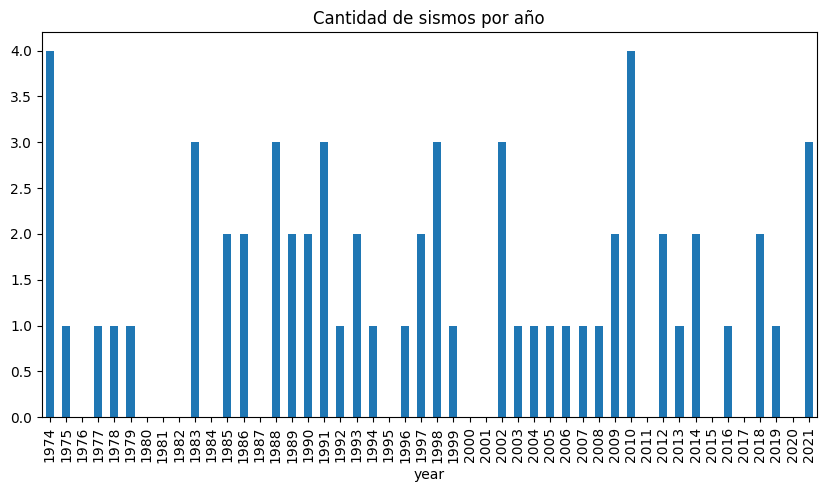

In [4]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'],format='ISO8601')

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

In [5]:
# Chequear media y varianza
mu1 = Data['mag'].mean()
s1 = Data['mag'].var()
print('media',mu1)
print('varianza',s1)

# Numero de intervalos
sum_DT = len(Data)
print('El intervalo total es',sum_DT,'años')

# Cantidad de sismos totales
sum_xi = np.sum(Data['mag'])
print('La cantidad de sismos en el tiempo medido es',sum_xi)

media 1.3125
varianza 1.2832446808510638
El intervalo total es 48 años
La cantidad de sismos en el tiempo medido es 63


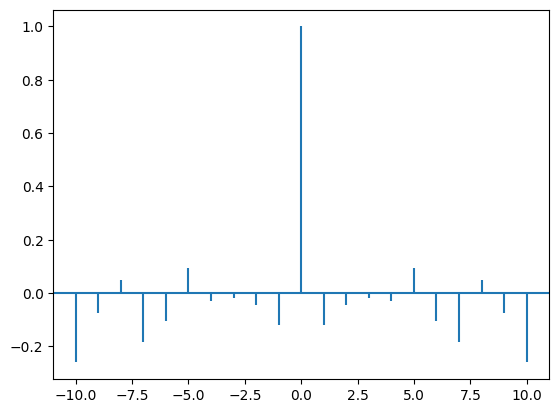

In [6]:
# Autocorrelación
plt.acorr( Data['mag']-Data['mag'].mean() );

#### Modelo 1

En este curso, vamos a utilizar la librería `Bambi`, una versión más amigable con el usuario de `PyMC`, que permite muy rápidamente y de forma relativamente sencilla construir modelos y hacer inferencia.

In [7]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

# Import Arviz para ver los resultados
import arviz as az

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.7 MB/s eta 0:00:00


##### Construcción del modelo

Básicamente, un modelo se construye definiendo `bmb.model` donde se incluirá:

- La fórmula que explica a la variable (de qué depende), escrita en términos de los *nombres de las columnas* del DataFrame con los datos
- Qué DataFrame vamos a usar
- Qué tipo de modelo generación de datos se va a utilizar (por default está seteado el modelo Normal, pero puede ser uno Exponencial, de Poisson, Bernoulli, Binomial-Negativa, etc.)

En el caso de un ajuste de una función de distribución, el modelo "no tiene variables", así que la fórmula es constante:

**Nota**: Se identifica `link='identity'` porque lo que queremos ajustar es el valor del parámetro en si. Después veremos que este link permite generar distintos tipos de modelos.

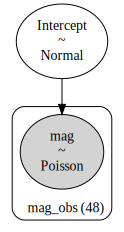

In [8]:
# Modelo de Poisson
model_new = bmb.Model("mag ~ 1", Data, family='poisson',link='identity')

# Ver el modelo
model_new.build()
model_new.graph()

##### Distribuciones a priori

Una cosa útil (pero no necesariamente didáctica) que tiene `Bambi` es que para los modelos que ya tiene cargados automáticamente (otros hay que incorporarlos a mano) ya define por vos distribuciones a priori poco-informativas de los parámetros.

Como mencionamos antes, no serán completamente no-informativas porque en general estas no son verdaderas distribuciones de probabilidad y no se pueden simular.

Más allá de eso, si tienen dudas pueden visualizar las distribuciones a priori del modelo con `plot_priors()`.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


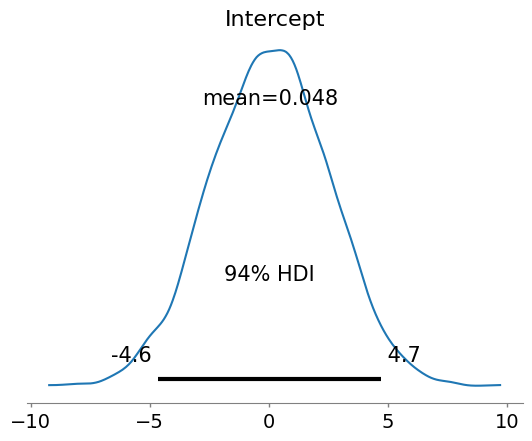

In [9]:
# Grafico las distribuciones a priori
model_new.plot_priors()
plt.show()

Acá es donde tienen que tener cuidado, ya que las distribuciones a priori de `Bambi` están hechas para los valores por default del modelo (nosotros cambiamos el `link`), y pueden no tener sentido.

En este caso, nosotros sabemos que $\lambda>0$, así que esta distribución a priori no sirve! Veamos entonces como construir una (y les vamos a pedir a lo largo del curso que las definan ustedes).

Yo puedo (y debería) definir las distribuciones a priori que yo quiera. Recordemos que son decisión del modelador. Esto se hace con la opción `priors`.

Algunas distribuciones típicas son:

- La Normal para datos que toman cualquier valor (con desvío grande si queremos algo poco informativo)
- La HalfNormal (o HalfStudentT) o la Exponencial, o Gamma para datos positivos

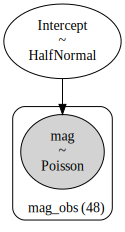

In [10]:
# Elegir Priors ------------------
priors = {"Intercept": bmb.Prior("HalfNormal",sigma=10)}

model_new = bmb.Model("mag ~ 1", Data, family='poisson',priors=priors,link='identity')

# Ver el modelo
model_new.build()
model_new.graph()

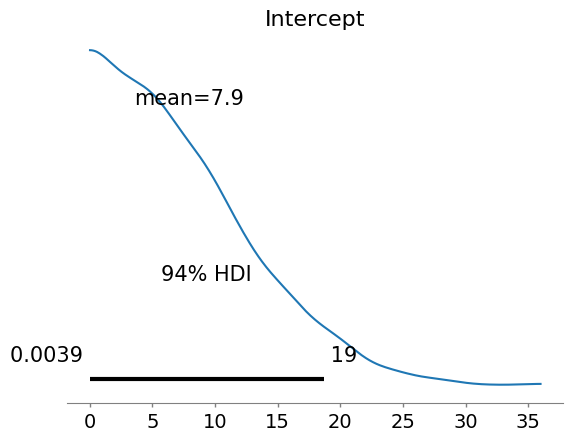

In [11]:
# Grafico las distribuciones a priori
model_new.plot_priors()
plt.show()

**Comentario**: Ninguna de estas distribuciones a priori lleva a una solución analítica, no queda otra que simular!

La pregunta que uno debiera hacerse siempre es, ¿estoy logrando lo que quiero con mis distribuciones a priori? No siempre es tan intuitivo!

Por ejemplo, si yo quería una distribución difusa, yo esperaría que el modelo "sin datos" arroje simulaciones que tomen un amplio rango de valores razonables. Por ejemplo, para sismos en San Juan si no tengo datos espero que mis distribuciones a priori devuelvan casi cualquier cosa entre 0 y 5 sismos por año sin introducir mucho bias (salvo que así lo quiera).

Esto se lo conoce como "Prior Check".

In [12]:
 # Evaluacion de las distribuciones a priori
 results = model_new.prior_predictive()

Esta variable results es donde estaremos guardando todos nuestros resultados del modelo. Veamos qué tiene dentro:

In [13]:
results

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Como ven, son simulaciones del intercept, y simulaciones de sismos por año asumiendo que no vi datos (es decir, usando solo la distribución a priori).

Verán que las simulaciones en `prior_predictive` tienen dimensiones (1,500,48). Eso es porque simulo 1 vez, 500 ensayos de 48 datos (de la misma dimensión que los datos observados). ¿Les suena? Lo habíamos usado en forma similar para evaluar la inferencia.

Veamos qué da. ¡La ventaja con Bambi es que este gráfico se hace solo!

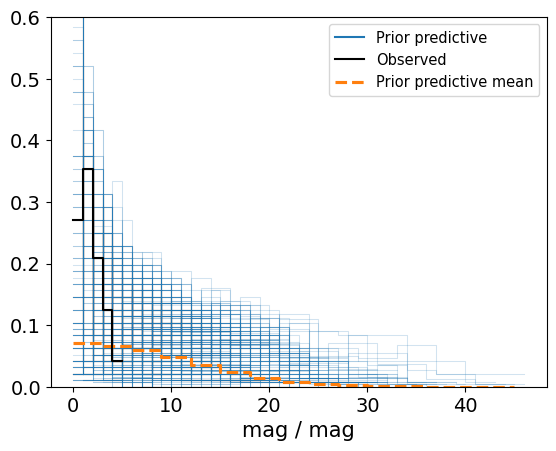

In [14]:
# Prior Check con Bambi
az.plot_ppc(results,group='prior')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

Como pueden ver, las distribuciones simuladas van desde casos donde hay 0 sismos por año la mayoría del tiempo a casos donde 30 sismos por año son muy probables. Nuestra distribución a priori parecer ser bien difusa (uno podría llegar a decir que demasiado, pero al momento eso no va a afectar).

**NOTA**: ¿Y si me quiero hacer yo el gráfico? ¡Puedo acceder a mano a los datos simulados! se encuentran en `prior_predictive`. Luego puedo manipularlos para hacer los gráficos que hice antes.

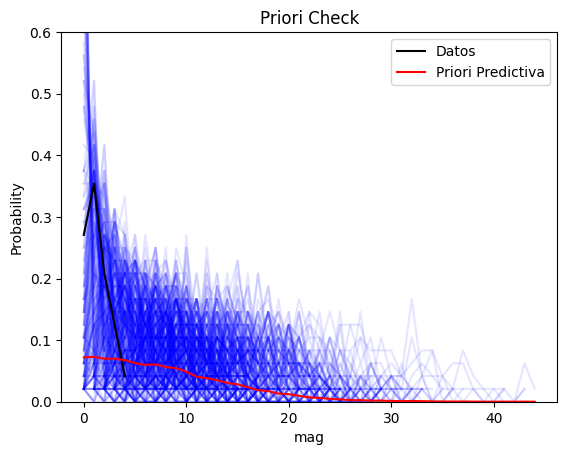

In [15]:
# Accedo a los datos de las simulaciones
X_sim = results.prior_predictive['mag']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(-1,len(Data['mag']))).T

# Grafico los 500 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),discrete=True,stat='probability',label='Priori Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Priori Check')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

Reconocer que `Bambi` siempre devuelve simulaciones es importante y la razón por la cual siempre venimos trabajando así en vez de con las funciones propiamente dichas, aún cuando había soluciones analíticas!

##### Realizar la inferencia estadística

¡Lo que queda nomás es hacer la inferencia! Y a que no se imaginan, se hace también con una línea de código.

Los parámetros que se pueden modificar son:

- El número de cadenas de markov: `chains`. Por default usa el valor más grande entre el número de núcleos de la PC y 2 (en colab, esto defaultea a 2). Esto es porque se pueden paralelizar y hacer más simulaciones en la misma cantidad de tiempo.
- El número de simulaciones en la cadena: `draws`. El default es 1000
- El número de iteraciones previas: `tune`. El default también es 1000
- Fijar la RNG para obtener resultados replicables: `random_seed`

Además se le puede agregar otros parámetros adicionales. Uno es que guarde los cálculos de log-verosimilitud (muy útil para seleccionar modelos). Otro también es modificar el `target_accept` (default 0.8), en caso de que la cadena tenga problemas de convergencia esto puede ayudar.

In [16]:
# Hago la inferencia estadística
results_new = model_new.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

**Nota**: El argumento `log_likelihood` es para que guarde los datos de log-verosimilitud, que pueden ser muy útiles.

Lo que sí tienen que prestar atención al hacer la inferencia es al resultado. **Siempre revisen que no haya divergencias**. De lo contrario tienen un problema (generalmente el modelo tiene alguna complicación, como pueden ser distirbuciones a priori mal definidas o incompatibles, etc.). A veces se puede subsanar aumentando el valor de `tune` or `target_accept`, si no es el problema el modelo en sí.

Es importante también visualizar qué ocurrió durante la inferencia. Para eso tenemos 2 herramientas, una visual y otra en forma de tabla:

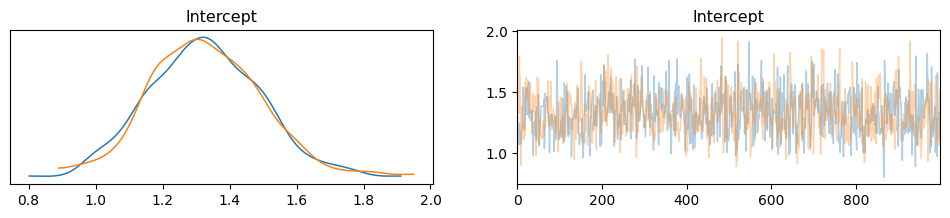

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  1.329  0.167   0.999    1.626      0.006    0.004     881.0   

           ess_tail  r_hat  
Intercept    1239.0    1.0

In [17]:
# Diagnóstico de la Cadena
az.plot_trace(results_new, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_new)

Acá se podría entrar en mucho detalle, pero lo importante es que vean que las cadenas se parezcan entre sí y que pareciera haber independencia. En cuanto a la tabla, numéricamente el valor de `r_hat` debiera ser prácticamente 1, es decir que la dispersión entre las cadenas es similar a la dispersión dentro de una cadena.

Si todo esto está OK, entonces la *inferencia está bien hecha* (no significa que el modelo sea bueno, son cosas distintas).

##### Distribuciones posteriores

De forma muy similar, podemos mirar entonces cuál es la distribución de los parámetros de nuestro modelo dado los datos observados. Noten que puedo elegir el intervalo de confianza a informar (por default es 0.94).

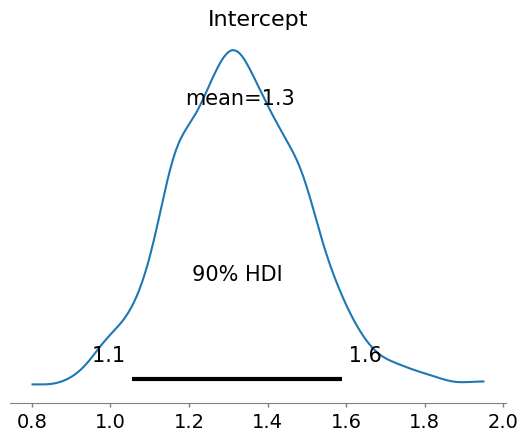

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  1.329  0.167   1.055     1.59      0.006    0.004     881.0   

           ess_tail  r_hat  
Intercept    1239.0    1.0

In [18]:
az.plot_posterior(results_new, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_new,hdi_prob=0.9)

Y lo mismo con la posterior predictiva, la cual primero hay que generar pidiendo que haga predicciones en base a los resultados con `predict`

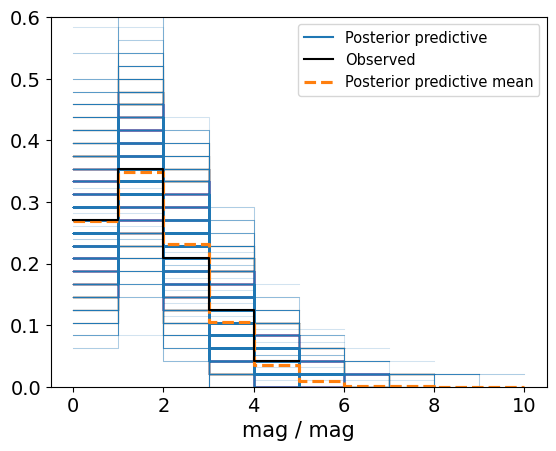

In [19]:
# Hacer predicciones con mi modelo
model_new.predict(results_new,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_new)
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

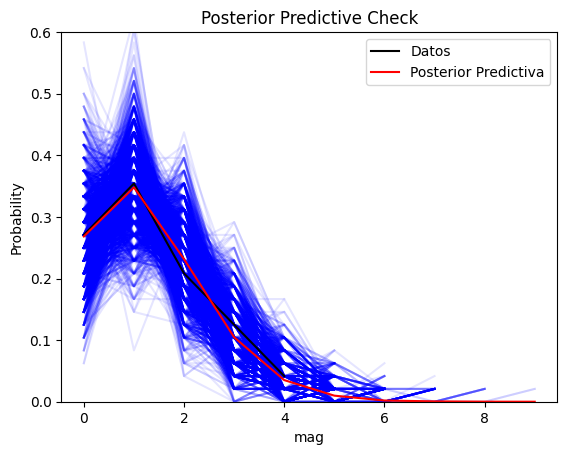

In [20]:
# Accedo a los datos de las simulaciones
X_sim = results_new.posterior_predictive['mag']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(-1,len(Data['mag']))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),discrete=True,stat='probability',label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Posterior Predictive Check')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

Como ven, el gráfico se parece mucho al que construimos antes, con 4000 simulaciones del ensayo. El resultado que después "me sirve" para predecir es ese promedio en rojo.

Noten además como, comparado con el "prior check", las simulaciones ahora están mucho más acotadas alrededor de los datos.

##### Acceso a los resultados

Una pregunta que se pueden hacer y es válida es "dónde están los datos de las simulaciones" para poder trabajarlos, calcular probabilidades, o incluirlos como parte de otro proyecto de simulación. O, por ejemplo, para ver los datos del parámetro en la escala que me interesa y no logarítmica.

Bueno, para acceder a ellos veamos qué hay dentro de la variable que creamos con nombre `results_new`

In [21]:
results_new

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Como pueden ver, en `posterior` pueden acceder a las simulaciones de los parámetros, y en `posterior_predictive` a las simulaciones de datos no-observados.

Pero van a notar algo raro, son arrays 3D! $(n,x,y)$. Bueno, esto es porque:
- $n$ son las cadenas de Markov que se usaron para la inferencia
- $x$ son la cantidad de simulaciones que se hicieron dentro de cada cadena de la muestra
- $y$ es la cantidad de muestras de mi dataset.

Es como hicimos antes, $n\cdot x$ réplicas de una muestra como la de los datos, que es lo veiamos en el gráfico anterior. La posterior predictiva es el promedio de todo eso. Para este caso, podemos calcularla agarrando todas las simulaciones y poniendolas en un solo vector con `np.ravel` por ejemplo.

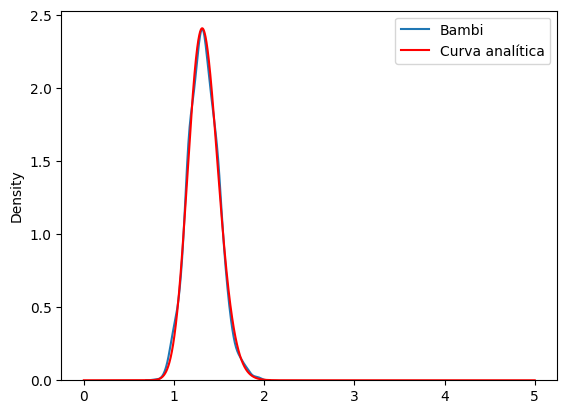

In [22]:
# Simulaciones del parámetro
param_new = np.ravel(results_new.posterior['Intercept'])

# Solución analitica (Opcion 1)
# ==============================================================================
import scipy.stats as st
alpha = 1
beta = 0
# Modelos analiticos de la solucion
lam_an = st.gamma(alpha+sum_xi,scale=1/(beta+sum_DT))
X_an = st.nbinom(alpha+sum_xi,(beta+sum_DT)/(1+(beta+sum_DT)))

# Vector para la evaluacion
ki = np.array(range(10000))/2000
Xi = np.array(range(9))
pli = lam_an.pdf(ki)
pXi = X_an.pmf(Xi)
# ==============================================================================

sns.kdeplot(param_new,label='Bambi')
plt.plot(ki,pli,label='Curva analítica',color='red')
plt.legend()
plt.show()

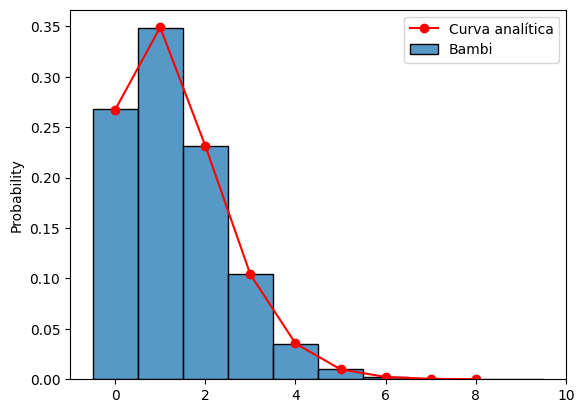

In [23]:
# Simulaciones de sismos por año
y_post = np.ravel(results_new.posterior_predictive['mag'])
sns.histplot(y_post,discrete=True,stat='probability',label='Bambi')
plt.plot(Xi,pXi,label='Curva analítica',color='red',marker='o')
plt.legend()
plt.show()

¡Como ven, dio básicamente lo mismo! Tengan en mente siempre cómo pueden acceder a las simulaciones, ya sea para construir sus propios gráficos o para hacer los cálculos que necesiten.

#### Modelo 2

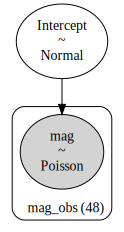

In [24]:
# Construyo un modelo de poisson en Bambi
model_poisson = bmb.Model("mag ~ 1", Data,family='poisson')
model_poisson.build()

# Ver el modelo
model_poisson.graph()

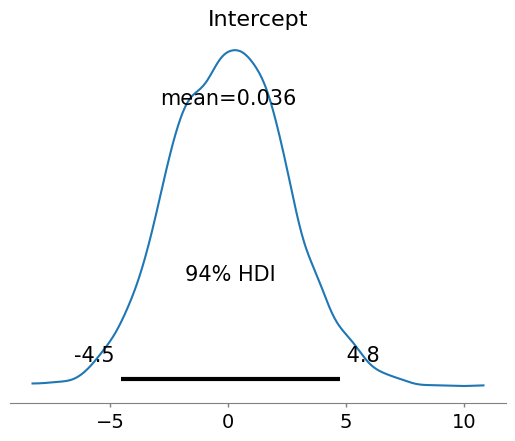

In [25]:
# Grafico las distribuciones a priori
model_poisson.plot_priors()
plt.show()

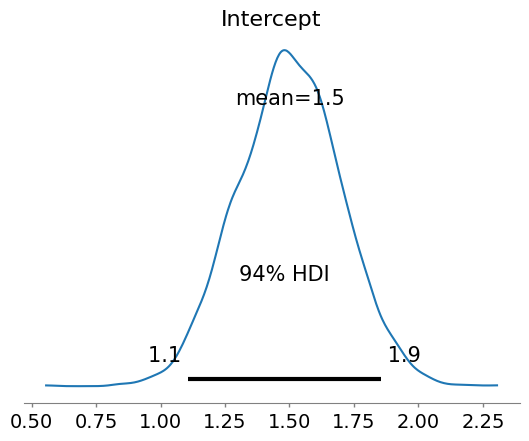

In [26]:
# Modificacion de distribución a priori
priors = {"Intercept": bmb.Prior("Normal",mu=1.5,sigma=0.2)}

# Construyo un modelo de poisson en Bambi
model_poisson = bmb.Model("mag ~ 1", Data,family='poisson',priors=priors)
model_poisson.build()

# Mostrar Distribuciones a Priori
model_poisson.plot_priors()
plt.show()

In [27]:
 # Evaluacion de las distribuciones a priori
 results = model_poisson.prior_predictive()

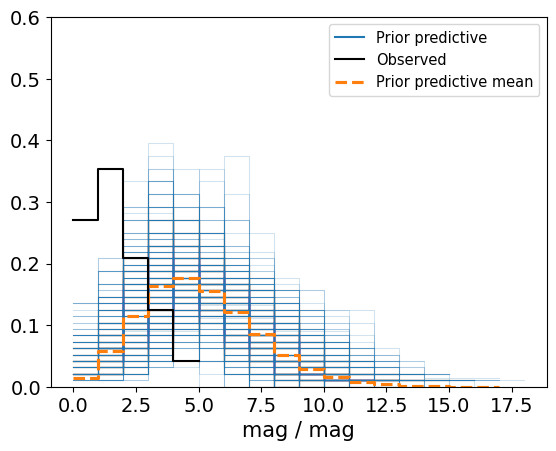

In [28]:
# Prior Check con Bambi
az.plot_ppc(results,group='prior')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

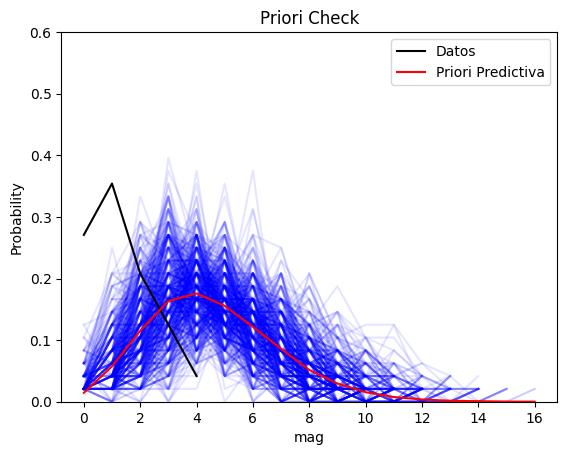

In [29]:
# Accedo a los datos de las simulaciones
X_sim = results.prior_predictive['mag']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(-1,len(Data['mag']))).T

# Grafico los 500 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),discrete=True,stat='probability',label='Priori Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Priori Check')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

In [30]:
# Hago la inferencia estadística
results_poisson = model_poisson.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

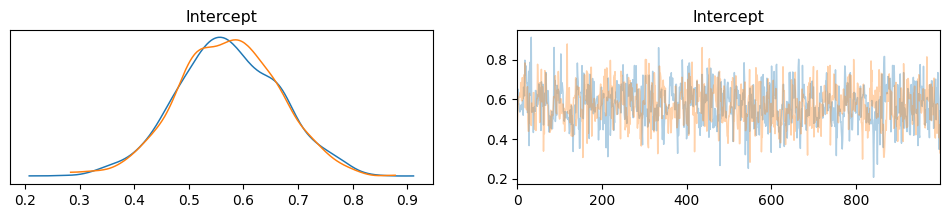

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.572  0.094   0.397    0.751      0.003    0.002     754.0   

           ess_tail  r_hat  
Intercept    1317.0    1.0

In [31]:
# Diagnóstico de la Cadena
az.plot_trace(results_poisson, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_poisson)

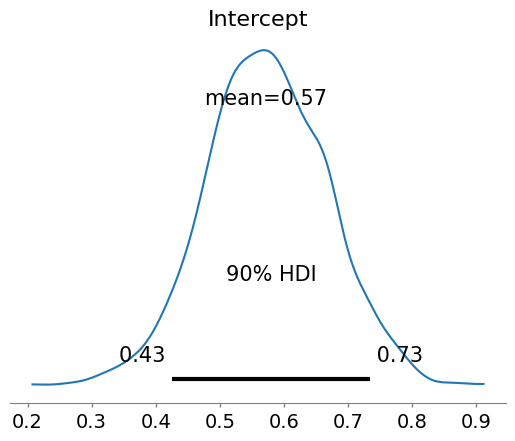

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.572  0.094   0.426    0.734      0.003    0.002     754.0   

           ess_tail  r_hat  
Intercept    1317.0    1.0

In [32]:
az.plot_posterior(results_poisson, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_poisson,hdi_prob=0.9)

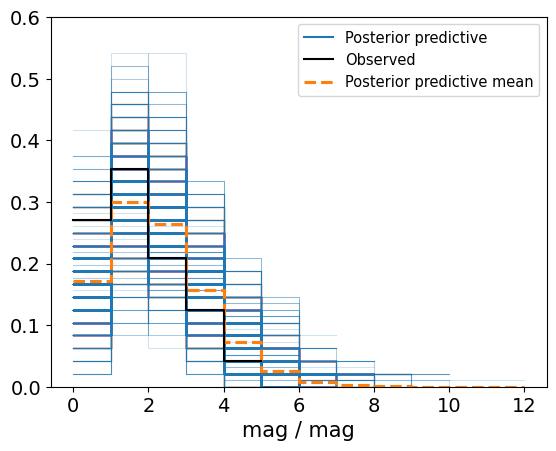

In [33]:
# Hacer predicciones con mi modelo
model_poisson.predict(results_poisson,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_poisson)
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

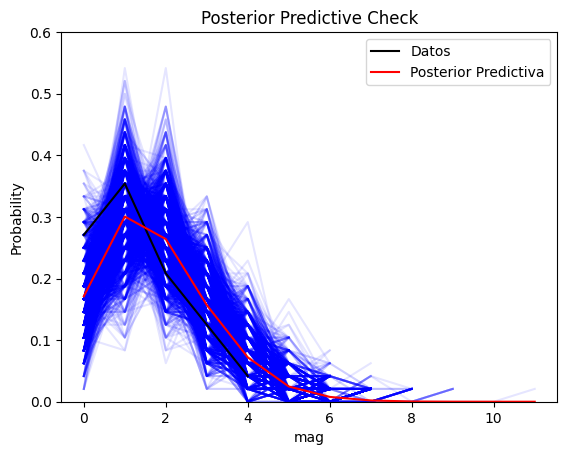

In [34]:
# Accedo a los datos de las simulaciones
X_sim = results_poisson.posterior_predictive['mag']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(-1,len(Data['mag']))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),discrete=True,stat='probability',label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Posterior Predictive Check')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.show()

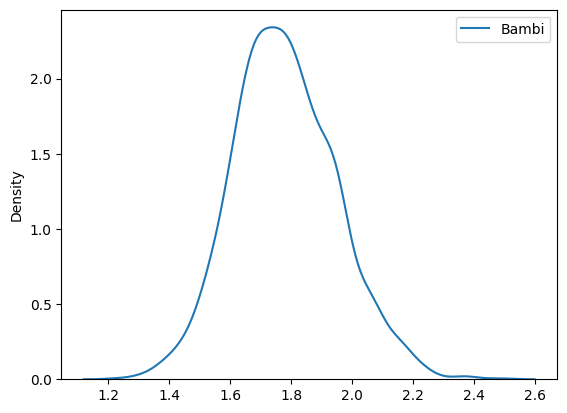

In [35]:
# Simulaciones del parámetro
log_param = np.ravel(results_poisson.posterior['Intercept'])
param = np.exp(log_param)

sns.kdeplot(param,label='Bambi')
plt.legend()
plt.show()

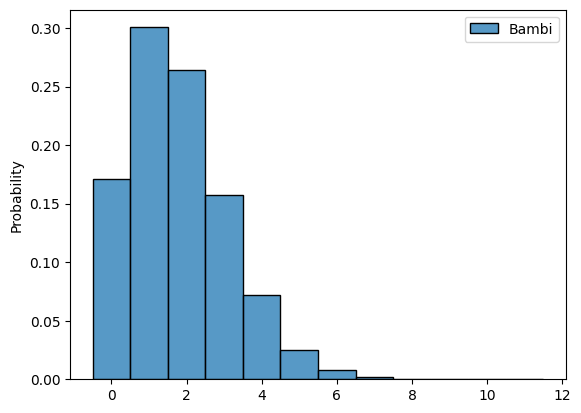

In [36]:
# Simulaciones de sismos por año
y_post = np.ravel(results_poisson.posterior_predictive['mag'])
sns.histplot(y_post,discrete=True,stat='probability',label='Bambi')
plt.legend()
plt.show()

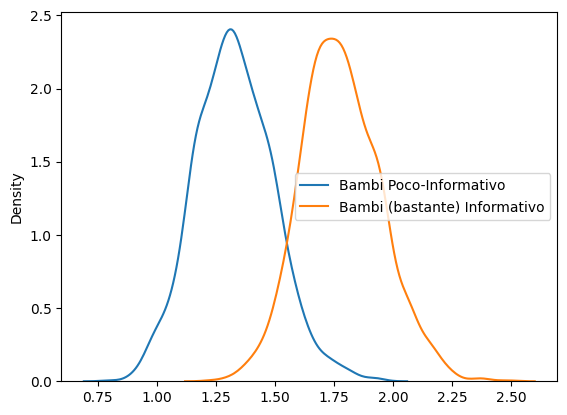

In [37]:
sns.kdeplot(param_new,label='Bambi Poco-Informativo')
sns.kdeplot(param,label='Bambi (bastante) Informativo')
plt.legend()
plt.show()

### Evaluación de la predictiva

Veamos nuevamente la siguiente pregunta ¿Cómo veo si mis datos se parecen a lo que predice mi modelo ajustado? A este tipo de revisión se lo conoce como Posterior Predictive Check. La idea es ver entonces si los datos que vi son probables según mi modelo (hablando en forma simplificada)

#### Curvas de densidad o probabilidad acumulada

Lo más común es comparar histogramas. Es decir, la curvas de densidad de probabilidad (o probabilidad de masa) y las curvas de probabilidad acumulada. Para hacer los resultados más visuales, se suelen graficar muchos histogramas, que representan realizaciones de mi ensayo con el modelo predictivo.

Es decir, si yo ajusté mi modelo con 48 datos, voy a construir 4000 histogramas de 48 datos, obtenidos mediante simulación de los parámetros de mi distribución posterior (predictiva).

Como vimos la clase pasada, hay forma de hacer esto a mano, pero para empezar usemos las funciones de arviZ que lo hacen por nosotros

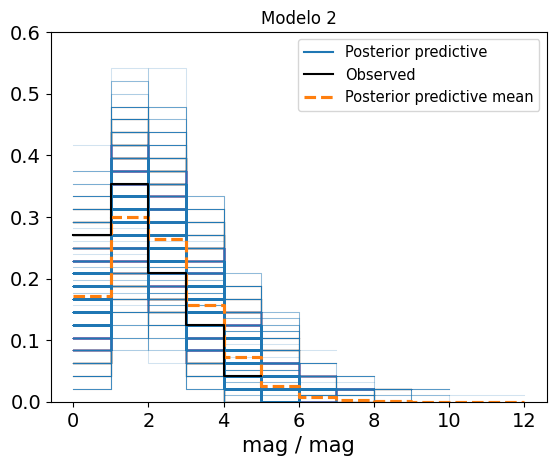

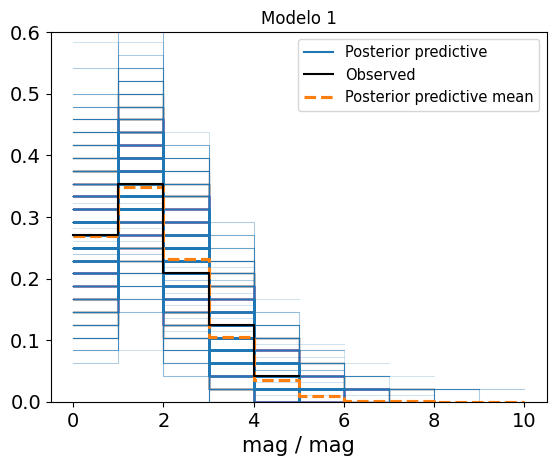

In [38]:
# Hacer predicciones con mi modelo (YA HECHO ARRIBA)
# model_poisson.predict(results_poisson,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_poisson)
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.title('Modelo 2')
plt.show()

# Visualizar predicciones
az.plot_ppc(results_new)
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.title('Modelo 1')
plt.show()

Acá pueden comparar en primera instancia, cuánto se parecen la curva naranja de la negra, ya que esa es la diferencia entre los datos y el modelo. Las curvas azules son las distintas realizaciones de ensayos de igual magnitud a los datos con el modelo predictivo. Esto me da una idea de qué tan probable es ver ciertos histogramas.

Si la línea negra (observado) cae dentro de la zona azul más oscura, eso me indica que la posibilidad de ver los datos en 48 años es probable. Es decir, los datos son consistentes con el modelo (no tiene por qué justo darme sobre la línea naranja, no? Porque no vi infinitos datos, solo unos cuantos).

Si yo viese que mis datos son una realización muy improbable de mi modelo, entonces ya empezaría a pensar que mi modelo no se ajusta realmente a los datos.

Este gráfico puede hacer también para la función de probabilidad acumulada!

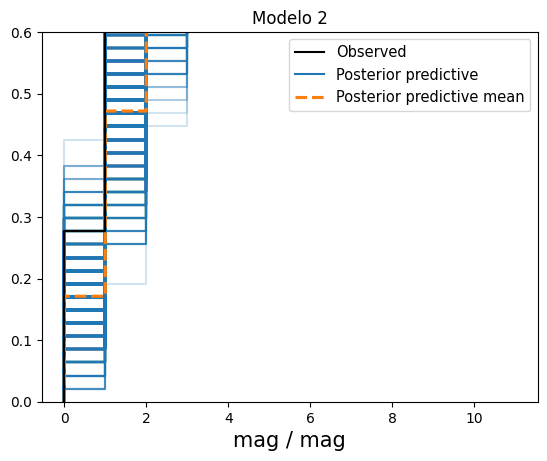

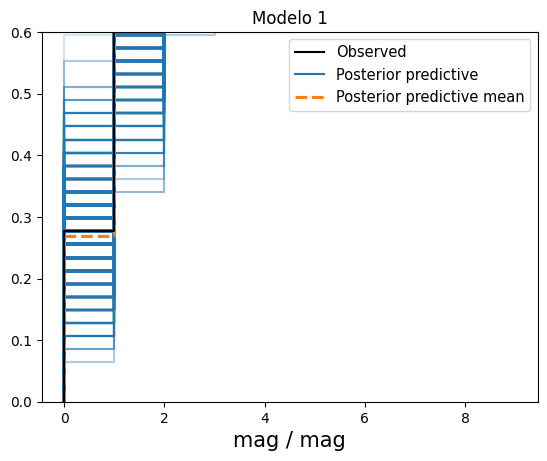

In [39]:
# Hacer predicciones con mi modelo
#model_poisson.predict(results_poisson,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_poisson,kind='cumulative')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.title('Modelo 2')
plt.show()

# Visualizar predicciones
az.plot_ppc(results_new,kind='cumulative')
plt.yticks(np.array(range(10))/10)
plt.ylim([0,0.6])
plt.title('Modelo 1')
plt.show()

En el próximo ejercicio, que es sobre variables continuas, estos gráficos tal vez se vean un poco más claros.

#### Algún dato en particular

Exactamente el mismo análisis puedo hacer para evaluar ya no la distribución en sí, sino tal vez algún parámetro de mi distribución.

Por ejemplo, veamos la media de la distribución predictiva.

Una aclaración: **La media de la distribución predictiva es un dato**. No es una función de distribución, es un valor de la población. Pero sí puedo construirme un histograma de qué me daría el valor medio para distintas realizaciones del ensayo, para ver qué tan probable era ver el valor medio que tenían mis datos según el modelo (es decir, en un sampleo de 48 datos de mi población).

Lo que tendremos que hacer, para este caso por ejemplo, es calcularle a cada de una de las 2000 realizaciones del ensayo de 48 datos el valor medio y graficar el histograma!

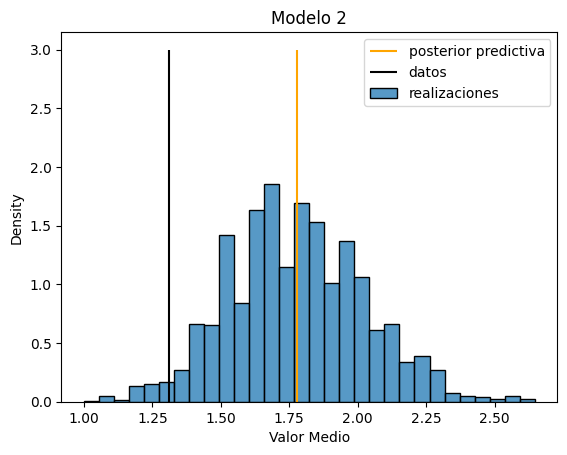

In [40]:
# Calculo el valor medio
mean_sim = results_poisson.posterior_predictive['mag'].mean(axis=2)

# Valor medio de la predictiva
mean_pred = np.ravel(results_poisson.posterior_predictive['mag']).mean()

# Valor medio de los datos
mean_dat = Data['mag'].mean()

# Histograma
sns.histplot(np.ravel(mean_sim),stat='density',label='realizaciones')
plt.vlines(mean_pred,0,3,color='orange',label='posterior predictiva')
plt.vlines(mean_dat,0,3,color='black',label='datos')
plt.xlabel('Valor Medio')
plt.title('Modelo 2')
plt.legend()
plt.show()

Fijensé que, por ejemplo, haber visto un valor medio de 1.3 en los datos dado mi modelo (Modelo 2) era algo relativamente poco probable.

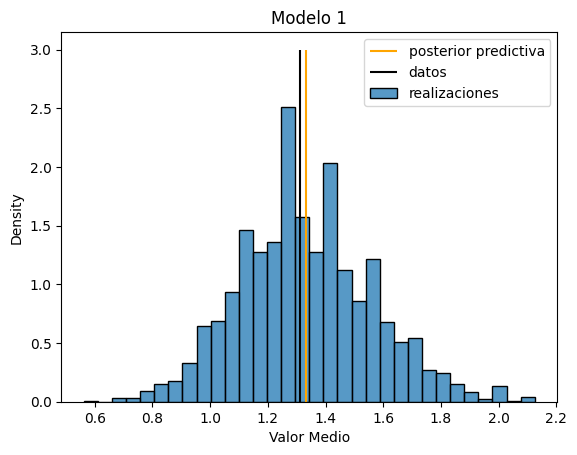

In [41]:
# Calculo el valor medio
mean_sim = results_new.posterior_predictive['mag'].mean(axis=2)

# Valor medio de la predictiva
mean_pred = np.ravel(results_new.posterior_predictive['mag']).mean()

# Valor medio de los datos
mean_dat = Data['mag'].mean()

# Histograma
sns.histplot(np.ravel(mean_sim),stat='density',label='realizaciones')
plt.vlines(mean_pred,0,3,color='orange',label='posterior predictiva')
plt.vlines(mean_dat,0,3,color='black',label='datos')
plt.xlabel('Valor Medio')
plt.title('Modelo 1')
plt.legend()
plt.show()

Mientras que con el modelo 1 el valor medio que vi con mis datos era básicamente el esperado.

Este mismo analisis lo puedo hacer para cualquier variable de interés (cuantiles, probabilidades, desvío estándar, kurtosis, etc.)

## Ejemplo 2: QQ-Plots y Evaluación entre modelos (Sismos en San Juan)

En este segundo ejemplo vamos a seguir trabajando sobre el dataset anterior, pero modelando el tiempo entre sismos en vez de la cantidad de sismos por año. Recordarán que si la cantidad de sismos sigue una distribución de Poisson con parámetro $\lambda$, el tiempo entre sismos sigue una distribución exponencial con parámetro $1/\lambda$.

A fines de la clase, este modelo nos va a permitir ver las herramientas de evaluación de modelos aplicado a modelos de variables continuas, y tal vez ayuda a ver mejor los gráficos que hicimos antes para variable discreta.

### Tiempo entre sismos

Lo primero que vamos a hacer es, con el dataset limpiado, calcular efectivamente el tiempo entre sismos principales, y ver su histograma.

In [42]:
# Extraer dd-mm-yyyy de la columna time y pasar a datetime
df_sismos['time_short'] = df_sismos['time'].astype(str).str[:10]
df_sismos['time_short'] = pd.to_datetime(df_sismos['time_short'])
# Calcular distancia en dias y pasar a float
df_sismos['T'] = df_sismos['time_short'].diff()
df_sismos['T'] = -df_sismos['T'].dt.days.astype(float)

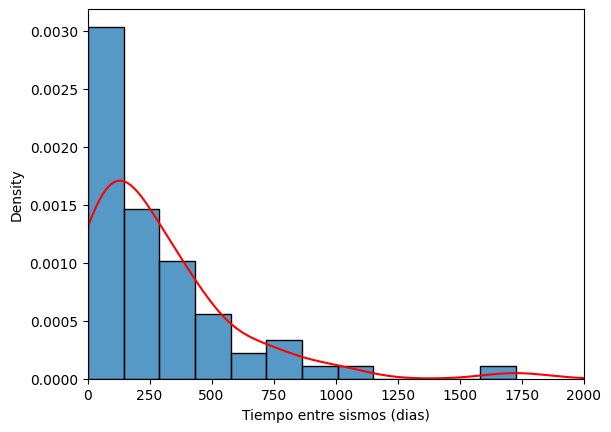

In [43]:
sns.histplot(df_sismos['T'],stat='density')
sns.kdeplot(df_sismos['T'],color='red')
plt.xlim([0,2000])
plt.xlabel('Tiempo entre sismos (dias)')
plt.show()

Efectivamente, los datos parecen seguir dentro de todo una distribución exponencial. Una forma de chequear esto sería calculando su media y desvío estandar (debieran ser iguales)

In [44]:
med = np.mean(df_sismos['T'])
std = np.std(df_sismos['T'])
print('La media es:',med)
print('El desvío es:',std)

La media es: 281.66129032258067
El desvío es: 301.81686091704506


¡Efectivamente son bastante parecidas! Pero no necesariamente iguales. Una opción es que el tiempo entre sismos no siga una distribución exponencial sino una Gamma (que es, por decirlo de una manera, una generalización de la exponencial con 2 parámetros).

Otra opción es que sea una lognormal. ¿Por qué no chequeamos ver el histograma del logaritmo? Si se ve hiperbólico, entonces el resultado es más parecido a una exponencial. Si el resultado es normal, el modelo podría ser lognormal.

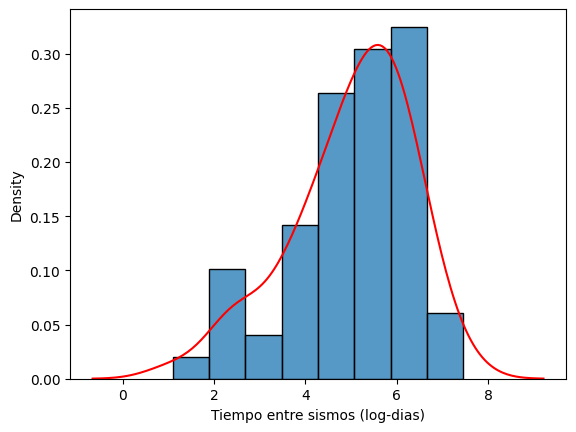

In [45]:
sns.histplot(np.log(df_sismos['T']),stat='density')
sns.kdeplot(np.log(df_sismos['T']),color='red')
plt.xlabel('Tiempo entre sismos (log-dias)')
plt.show()

Como vemos, parece haber chances de que el modelo que gobierne sea log-normal, aunque la asimetría en los datos no es tan parecida. ¡Pero ya veremos!

### Modelo Exponencial

Emepecemos por el modelo más sencillo (la exponencial, ya que tiene un sólo parámetro). Como ya vimos cómo se trabaja con `Bambi`, en este ejemplo haremos las cosas más rápido (y por default).

Siempre recuerden que los pasos son siempre los mismos, y que les recomendamos definir a ustedes la distribución a priori (y verificar que hace lo que quieren). Noten el uso de `dropna='True'`, ya que si tengo 63 sismos tengo 62 intervalos entre sismos (uno de los datos del dataframe tiene `nan` como tiempo.)

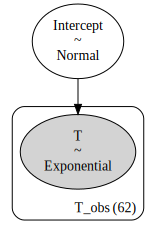

In [46]:
# Modelo Exponencial
model1 = bmb.Model("T ~ 1", df_sismos, family='exponential',dropna='True')

# Ver el modelo
model1.build()
model1.graph()

In [47]:
# Hago la inferencia estadística
results1 = model1.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

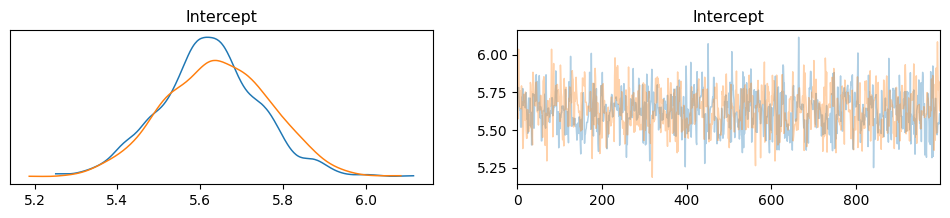

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  5.632  0.126   5.398    5.868      0.004    0.003     800.0   

           ess_tail  r_hat  
Intercept    1363.0   1.01

In [48]:
# Diagnóstico de la Cadena
az.plot_trace(results1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results1)

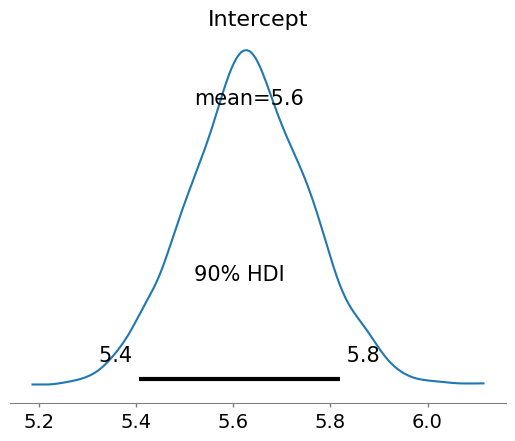

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  5.632  0.126   5.406     5.82      0.004    0.003     800.0   

           ess_tail  r_hat  
Intercept    1363.0   1.01

In [49]:
az.plot_posterior(results1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results1,hdi_prob=0.9)

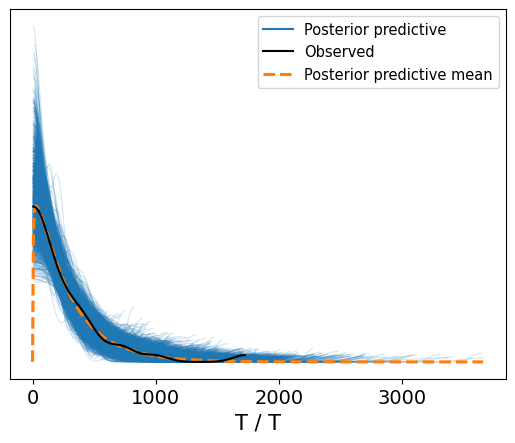

In [50]:
# Hacer predicciones con mi modelo
model1.predict(results1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results1)
plt.show()

### Modelo Gamma

Agreguemos un parámetro más al modelo anterior, convirtiéndolo en una Gamma. Esto tal vez permita ajustar mejor esa diferencia entre el valor medio y el desvío, a costa de un parámetro extra (¿será signigficativo?)

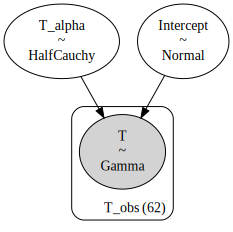

In [51]:
# Modelo Exponencial
model2 = bmb.Model("T ~ 1", df_sismos, family='gamma',dropna='True')

# Ver el modelo
model2.build()
model2.graph()

In [52]:
# Hago la inferencia estadística
results2 = model2.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

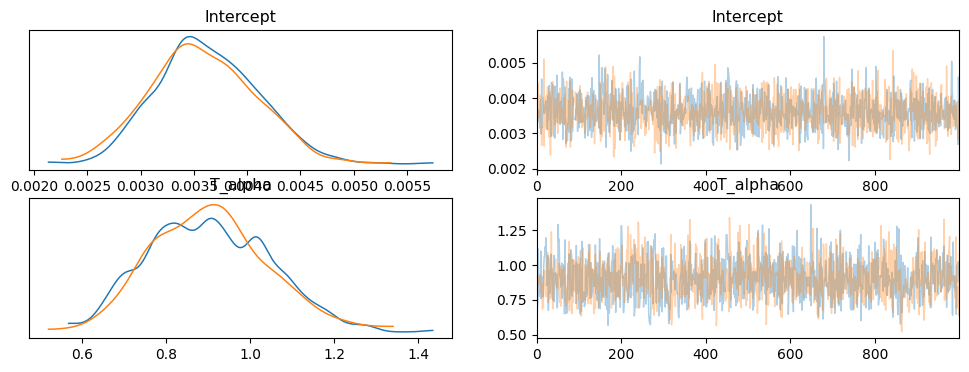

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.004  0.00   0.003    0.005      0.000    0.000    1830.0   
T_alpha    0.904  0.14   0.645    1.153      0.004    0.003    1387.0   

           ess_tail  r_hat  
Intercept    1479.0    1.0  
T_alpha      1188.0    1.0

In [53]:
# Diagnóstico de la Cadena
az.plot_trace(results2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results2)

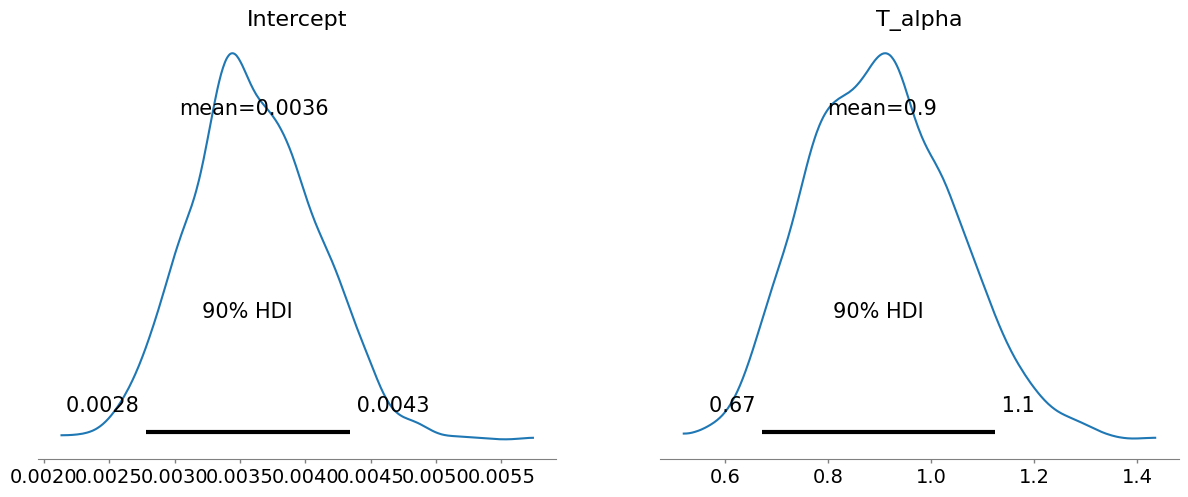

mean    sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.004  0.00   0.003    0.004      0.000    0.000    1830.0   
T_alpha    0.904  0.14   0.672    1.124      0.004    0.003    1387.0   

           ess_tail  r_hat  
Intercept    1479.0    1.0  
T_alpha      1188.0    1.0

In [54]:
az.plot_posterior(results2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results2,hdi_prob=0.9)

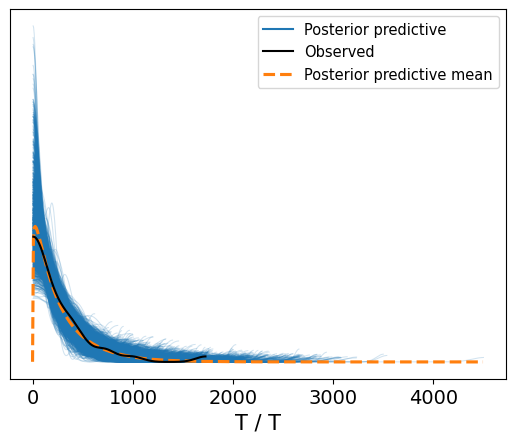

In [55]:
# Hacer predicciones con mi modelo
model2.predict(results2,kind='pps')

# Visualizar predicciones
az.plot_ppc(results2)
plt.show()

### Modelo Lognormal

Finalicemos con el modelo lognormal! Este ya es un poco más dificil de introducir, porque no está por default (se podría hacer la inferencia para el logaritmo como Gaussiana). Pero su formato es siempre parecido.

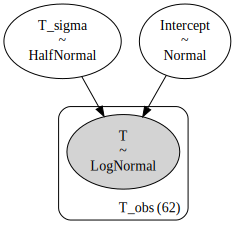

In [56]:
# Construyo un modelo lognormal en Bambi

# Construir Función de Verosimilitud ------------------------------
# El nombre tienen que ser una función que exista en PyMC
# 'parent' es la media de la distribucion (qué parametro tiene ese rol).
likelihood = bmb.Likelihood("LogNormal", params=["mu", "sigma"], parent="mu")

# Setear link ----------------------------------------------
link = {"mu": "identity"}

# Construir familia -------------------------------------------
family = bmb.Family("lognormal", likelihood, link)

# Elegir Priors ------------------
priors = {"Intercept": bmb.Prior("Normal",mu=0,sigma=100),
  "sigma": bmb.Prior("HalfNormal", sigma=10)}


model3 = bmb.Model("T ~ 1", df_sismos,family=family,priors=priors,dropna=True)
model3.build()

# Ver el modelo
model3.graph()

In [57]:
# Hago la inferencia estadística
results3 = model3.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

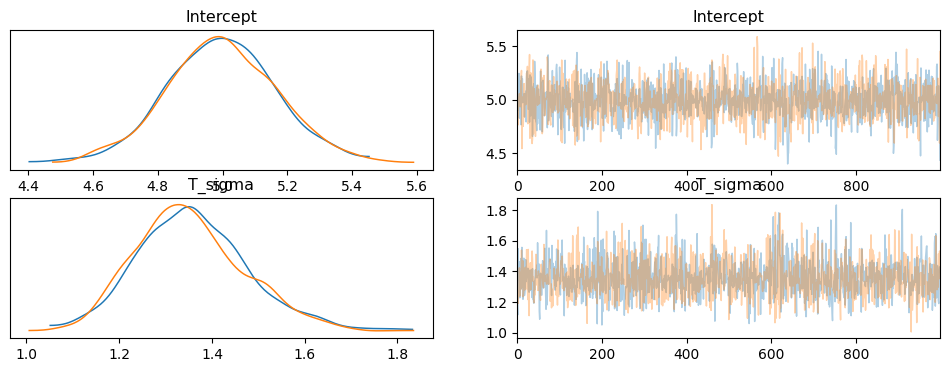

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.996  0.171   4.656    5.313      0.004    0.003    2174.0   
T_sigma    1.358  0.122   1.129    1.585      0.003    0.002    2073.0   

           ess_tail  r_hat  
Intercept    1290.0    1.0  
T_sigma      1263.0    1.0

In [58]:
# Diagnóstico de la Cadena
az.plot_trace(results3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results3)

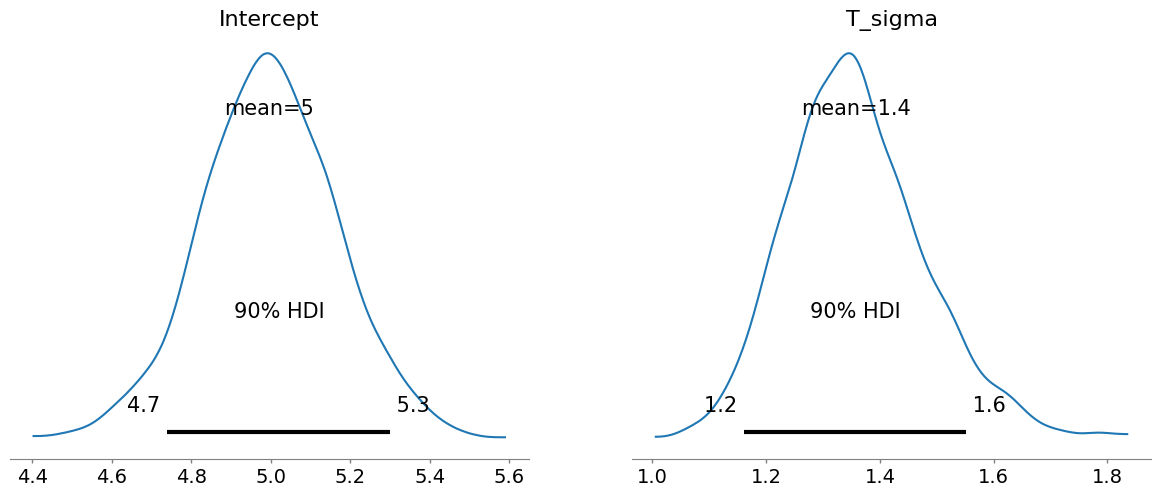

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.996  0.171   4.739    5.301      0.004    0.003    2174.0   
T_sigma    1.358  0.122   1.161    1.552      0.003    0.002    2073.0   

           ess_tail  r_hat  
Intercept    1290.0    1.0  
T_sigma      1263.0    1.0

In [59]:
az.plot_posterior(results3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results3,hdi_prob=0.9)

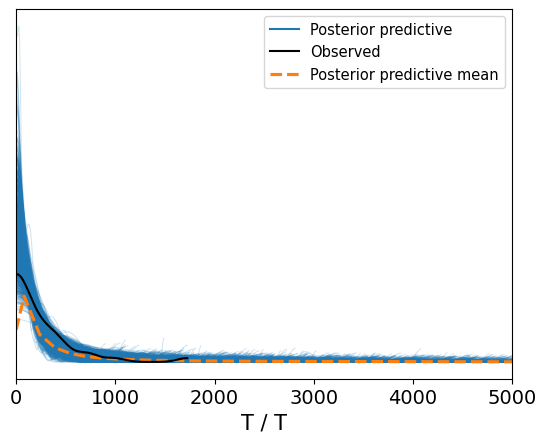

In [60]:
# Hacer predicciones con mi modelo
model3.predict(results3,kind='pps')

# Visualizar predicciones
az.plot_ppc(results3)
plt.xlim([0,5000])
plt.show()

Nota: El problema de la linea naranja es un artefacto del dibujo, eso se puede ver si lo hacemos "a mano".

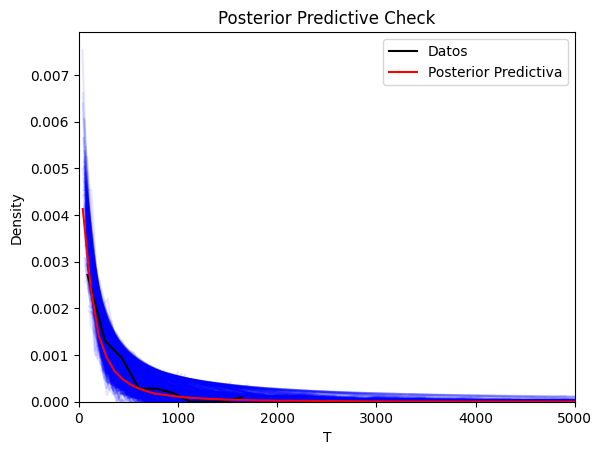

In [61]:
# Accedo a los datos de las simulaciones
X_sim = results3.posterior_predictive['T']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(-1,len(df_sismos['T'].dropna()))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],stat='density',bins=10,label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(df_sismos['T'].dropna(),stat='density',bins=10,label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),stat='density',bins=1000,label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Posterior Predictive Check')
plt.xlim([0, 5000])
plt.show()

### Evaluación de la predictiva - QQ-plots

Bueno, tenemos 3 modelos, y vimos tres gráficos de posterior predictive checks. En los 3 la curva negra  (datos) parece caer dentro de la nube azul de simulaciones, y se parecen dentro de todo a la curva posterior predictiva (naranja).

Podríamos seguir con la evaluación de la predictiva chequeando el valor medio, la kurtosis, o algún dato en particular que me gustase revisar, pero en este caso les vamos a mostrar otra forma de estudiar si dos distribuciones "se parecen" o no.

La herramienta en cuestión se llama QQ-plot, y lo que hace es graficar la relación entre los **Cuantiles de los datos** (En el eje Y en este caso) con los **Cuantiles del modelo** (En el eje X). Abajo les dejamos la función que lo construye creada por nosotros.

In [62]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  # Datos para el grafico
  xmin = np.min([np.min(Qx),np.min(Qy)])
  xmax = np.max([np.max(Qx),np.max(Qy)])

  # Plot
  fig = plt.figure(figsize=(5,5))
  plt.scatter(Qx,Qy)
  plt.plot([xmin,xmax],[xmin,xmax],'k-')
  plt.grid()
  plt.xlabel('Cuantiles Simulación')
  plt.ylabel('Cuantiles Muestras')
  #plt.show()

Veamos un primer ejemplo de como se ve un QQ-plot, tomando el caso de la distribución exponencial.

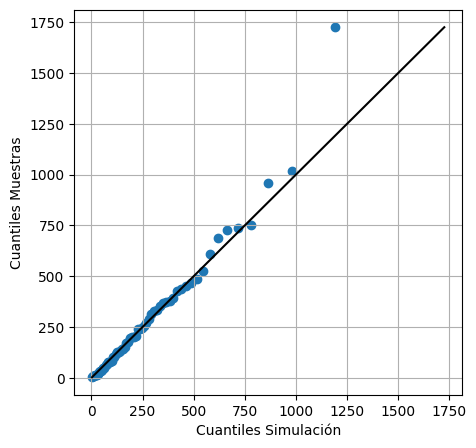

In [63]:
qqplot(np.ravel(results1.posterior_predictive['T']),df_sismos['T'].dropna())
plt.show()

¿Cómo se lee este gráfico? Hagamos unos tips!

1. La recta a 45 grados (en **negro**) es una recta que dice que los cuantiles de la simulación y de las muestras son iguales. Es decir, si mis puntos caen sobre la recta negra entonces las distribuciones de los datos y del modelo son iguales.
2. Si los puntos caen desfasados de la recta (misma pendiente, pero "corridos"), eso implica que los datos tienen una diferencia en el valor medio. Por lo pronto, consistentemente la simulación subestima el cuantil respecto a las muestras (si la recta esta corrida hacia la izquierda).
3. Es decir, la ubicación de los puntos me dicen cosas respecto del valor medio o del factor de locación
4. La pendiente de la recta es un indicador del desvío estandar. Si el desvío estándar de mi modelo es menor al de las muestras, yo vería que la recta me queda más empinada (sobreestima cuantiles bajos, subestima cuantiles altos). Caso contrario (predice mayor desvío), vería los puntos más planchados.
5. La curvatura de la "recta" es un indicador del skew o asimetría. Si los puntos están sobre una recta, entonces los datos tienen la misma asimetría. Pero si se curvan, entonces, son distintas. En particular, si la curvatura es negativa (panza hacia arriba en el gráfico), eso implica que la distribución del modelo tiene mayor asimetría derecha que los datos (es decir, hay más desbalance hacia la derecha del valor medio).
6. Por último, el peso de las colas se puede identificar viendo los extremos del QQ-plot. si sobre el final se pierde la recta (quedando una forma de S), eso implica que los datos tienen distintos pesos en las colas que las simulaciones. Lo más común es que les aparezca algún efecto de este estilo.

Como comentario, nunca esperen que los datos caigan perfecto en la recta, especialmente los datos extremos (en este caso, tiempos de espera muy largos), ya que los cuantiles de datos poco probables son muy sensibles a la muestra por un lado, y la incertidumbre en el modelo hace que la distribución predictiva tenga colas más pesadas

En particular, como ven en el caso de arriba los puntos siguen una recta a lo largo del eje negro, así que los datos y el modelo parecen seguir la misma distribución (datos vs modelo exponencial)

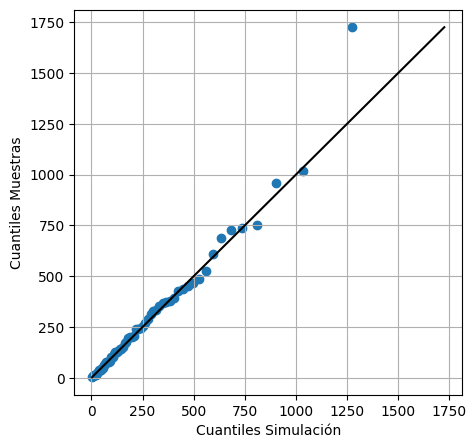

In [64]:
qqplot(np.ravel(results2.posterior_predictive['T']),df_sismos['T'].dropna())
plt.show()

Haciendo lo mismo para la distribución Gamma, nuevamente las simulaciones del modelo paracen caer sobre la recta a 45, así que se parecen a los datos.

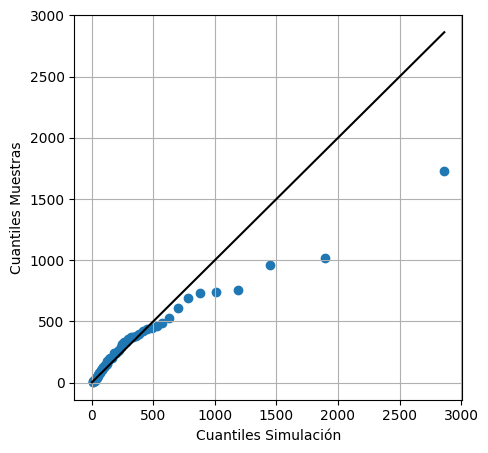

In [65]:
qqplot(np.ravel(results3.posterior_predictive['T']),df_sismos['T'].dropna())
plt.show()

Finalmente, en el modelo Log-normal vemos que ya no tengo una recta, sino que los resultados están curvados. Centrados (dentro de todo), pero curvados. Eso quiere decir que los datos simulados tienen más peso en la cola derecha (más asimetría) que los datos. A su vez, la pendiente media está corrida respecto a la recta negra, por lo que las simulaciones tienen mayor desvío.

En resumen, la lognormal al final parece ser que no era tan buena para ajustar a los datos (noten que estas mismas conclusiones se pueden ver en el gráfico del posterior predictive check).

### Selección de modelos (LOO-CV)

Lo anterior fue una nueva forma de evaluar el ajuste de un modelo en sí mismo. Y aunque comparativamente podíamos ver si un modelo se ajustaba más a la recta de 45 grados que otros, no deja de ser una herramiento más bien visual y cualitativa.

Lo que queremos para poder comparar y seleccionar modelos es tener alguna medida de la capacidad predictiva del modelo. Existen distintas formas de hacer esto (y las verán en la teórica). Hoy nos vamos a ocupar de una de ellas que es el Leave-One-Out Cross Validation.

La idea es la siguiente, si yo ajusto un modelo para todos los datos salvo uno, que tan bien puedo predicir ese dato que deje afuera (o, qué tan probable sería verlo con mi modelo? Y sSi me hago esa preguntando para todos los datos de a uno por vez, tendría una buena medida de qué tan capaz es mi modelo de predecir datos que no vio.

El problema es que ajustar el modelo N-1 veces es muy costoso, pero existen métodos para estimar el resultado sin tener que volver a pasar por las cadenas de Markov. Esto es lo que se conoce como PSISLOO (Pareto Smoothed Importance Sampling Leave One Out Cross Validation).

Por suerte, correrlo se vuelve una línea de código! Para ello, al hacer la inferencia era importante guardar las log-verosimilitudes.

La comparación entre modelos se realiza con `az.compare`. Las principales variables son definir el tipo de criterio `loo` o `waic`, y la escala de los resutlados (por default es `log`, pueden elegir también `deviance`)

In [66]:
# Diccionario con modelos a comparar
model_comp = {'Exponencial':results1,'Gamma':results2,'LogNormal':results3}

# Comparacion de modelos
az_comp_loo = az.compare( model_comp, ic='loo',scale='deviance')
az_comp_loo

rank    elpd_loo     p_loo  elpd_diff    weight         se  \
Exponencial     0  825.695852  1.186339   0.000000  0.955575  17.528125   
Gamma           1  827.110021  1.912991   1.414169  0.000000  17.458056   
LogNormal       2  835.123435  2.024641   9.427582  0.044425  17.858987   

                  dse  warning     scale  
Exponencial  0.000000    False  deviance  
Gamma        1.089833    False  deviance  
LogNormal    6.012241    False  deviance

Los resultados son devueltos ya rankeados de mejor a peor! Así que el mejor modelo es el primero en la lista, el exponencial. Veamos que significan las columnas:

- elpd_loo: el resultado de, en este caso, la deviance (log-predictive density) estimada por PSIS-LOO-CV
- p_loo: se lo suele pensar como el número de parámetros efectivos del modelo. Idealmente daría parecido al número de parámetros en tu modelo, caso contrario tal vez estés sobre ajustando los datos.
- elpd_diff: Simplemente la diferencia entre los deviances. Existen criterios para decir cuándo una diferencia es importante (por ejemplo, hay trabajos que indican que un `elpd_diff` menor a 4 entonces la diferencia es pequeña entre los modelos)
- weight: da la idea de cómo combinar las distribuciones en una mezcla para mejorar la predicción. El valor con mayor peso sería el modelo "único" más adecuado.
- se: es el error en la estimación del `elpd`
- dse: es el error (aproximadamente el desvío estandar) en la estimación del `elpd_diff`.

La idea sería la siguiente:
1. Ver si elpf_diff es mayor a 4. Si no lo es, ya no podría diferenciar entre modelos porque la estimación del `dse` como normal no es buena.
2. Si lo es, comparar `elpd_diff` contra `dse`. Si este ratio es mayor a 2 (la diferencia es mayor a 2 desvíos estandar), entonces la diferencia es siginifactiva (algunos autores acá toman un valor de 4 por que la estimación de `dse` es optimista)
2. Caso contrario, no puedo realmente distinguir entre los modelos.

En nuestra experiencia en el curso y con la cantidad de datos que trabajamos, en general estamos en esta situación donde la diferencia nunca llega a ser significativa. En ese sentido siempre recomendamos agarrar el mejor modelo entre los modelos sencillos (de menor cantidad de parámetros), incorporando también conocimiento del proceso físico (si hay razones para pensar que los datos vienen de una lognormal, y no puedo justificar con los datos un modelo distinto, voy con esa!). O, si quieren, el que tenga mayor peso asignado podría ser también una forma.

¡Los resultados se pueden ver de forma gráfica también!

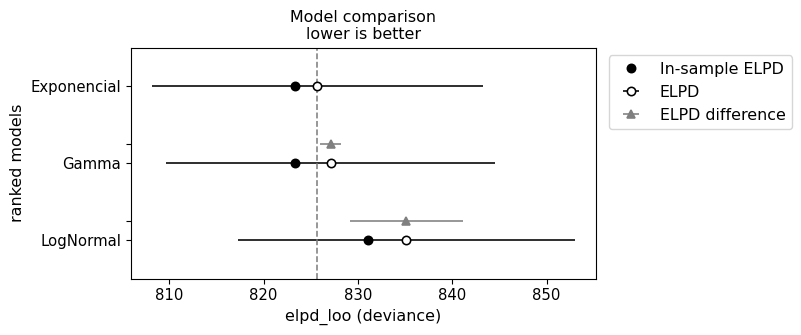

In [67]:
az.plot_compare(az_comp_loo,insample_dev=True)
plt.show()

Noten que el punto negro es la capacidad predictiva de los datos vistos, mientras que el blanco la de los datos no vistos. Fijense que el modelo Gamma (con un parámetro más), ajuste "algo mejor" los datos vistos, pero tiene peor efectividad que la exponencial para los datos no vistos. Esto es una señal de sobreajuste (demasiados parámetros para los datos que tengo).

Vean también que los triangulos muestran la diferencia entre capacidades predictivas con un más menos de 1 desvío estandar, como para ver gráficamente si puedo afirmar que un modelo es mejor que otro.

El resumen para este ejercicio, el mejor modelo es el exponencial!

## Ejemplo de modelos más complejos: Tiempo de demora en vuelos

Para los siguientes métodos de evaluación de modelos vamos a utilizar una nueva base datos, que contiene 2 años de vuelos con origen en los aeropuertos de Dallas-Fort Worth y Roanoke, en EE.UU.

Nuestro objetivo es construir un modelo para el tiempo de demora en la partida de los vuelos. El tiempo de demora es una variable continua que vale $0$ si el vuelo sale a tiempo (es decir, antes de su horario programado) y un valor real positivo si sale con posterioridad al horario estipulado.

**Nota**: La definción real de demora para el Departamento de Transporte de EE.UU. es 15min, veremos después cómo incluir esa información.

### Carga de datos

In [68]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving flights.csv to flights.csv


In [69]:
#Se crea un DataFrame
df_vuelos = pd.read_csv(io.BytesIO(uploaded['flights.csv']))
df_vuelos.head()

Year  Month  DayofMonth FlightDate Marketing_Airline_Network  \
0  2018      1           1   1/1/2018                        F9   
1  2018      1           3   1/3/2018                        F9   
2  2018      1           4   1/4/2018                        F9   
3  2018      1           4   1/4/2018                        F9   
4  2018      1           5   1/5/2018                        F9   

          OriginCityName DestCityName  CRSDepTime  DepTime  DepDelay  \
0  Dallas/Fort Worth, TX   Denver, CO         600      555        -5   
1  Dallas/Fort Worth, TX   Denver, CO         600      634        34   
2  Dallas/Fort Worth, TX   Denver, CO         600      603         3   
3  Dallas/Fort Worth, TX   Denver, CO        1845     1842        -3   
4  Dallas/Fort Worth, TX   Denver, CO         540      538        -2   

   DepDelayMinutes  CRSArrTime  ArrTime  ArrDelay  ArrDelayMinutes  AirTime  \
0                0         716      655       -21                0       95   
1               34         716      759        43               43       99   
2                3         716      732        16               16      108   
3                0        2001     1942       -19                0       99   
4                0         656      643       -13                0      102   

   Distance  
0       641  
1       641  
2       641  
3       641  
4       641

Descripción por columnas:
- Year: Año del vuelo
- Month: Mes del vuelo
- DayofMonth: Día del mes del vuelo
- FlightDate: Fecha del vuelo
- Marketing_Airline_Network: Aerolíneas: 'UA', 'DL', 'F9', 'NK', 'AA', 'WN', 'AS', 'HA', 'VX', 'B6', 'G4'
- OriginCityName: Ciudad de origen
- DestCityName: Ciudad de destino
- CRSDepTime: Tiempo programado de despegue (local time: hhmm)
- DepTime: Tiempo de despegue (local time: hhmm)
- DepDelay: Delay en min
- DepDelayMinutes: Delay en min (sin valores negativos)
- CRSArrTime: Tiempo programado de aterrizaje (local time: hhmm)
- ArrTime: Tiempo de aterrizaje (local time: hhmm)
- ArrDelay: Delay en min
- ArrDelayMinutes: Delay en min (sin valores negativos)
- AirTime: Tiempo de vuelo
- Distance: Distancia en millas

En esta clase vamos a mirar únicamente la columna `DepDelayMinutes`, que es efectivamente el tiempo de demora (0 si salió a tiempo). El dataset se presta para mucho más, pero eso se los dejamos a ustedes para lo que es análisis exploratorio y, luego, modelos de regresión.

¿Vemos cómo se ven los datos?

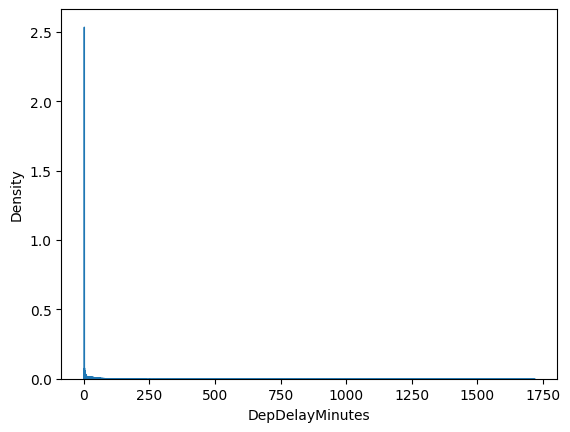

In [70]:
sns.histplot(df_vuelos['DepDelayMinutes'],stat='density',element='poly')
plt.show()

In [71]:
# Porcentaje de vuelos a tiempo
print('El porcentaje de vuelos que salen a tiempo es:',np.mean(df_vuelos['DepDelayMinutes']==0))

El porcentaje de vuelos que salen a tiempo es: 0.6504355486986231


Como ven hay un número gigante de 0's (vuelos a tiempo) que desnaturalizan un poco el gráfico). Veamos el histograma para los resultados **con** demora.



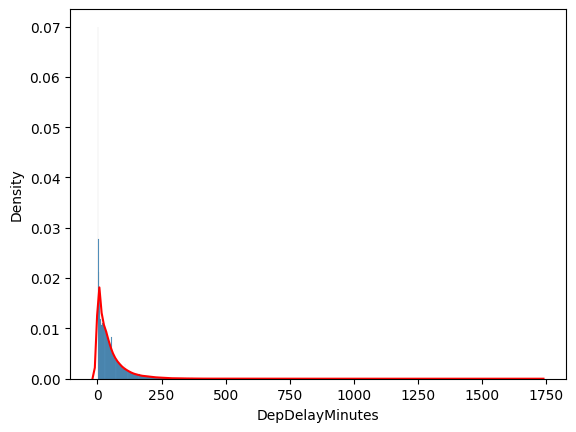

In [72]:
filt = df_vuelos[df_vuelos['DepDelayMinutes']!=0]
sns.histplot(filt['DepDelayMinutes'],stat='density')
sns.kdeplot(filt['DepDelayMinutes'],color='red')
plt.show()

El histograma se parece bastante a una exponencial, ¿no? Una característica de la distribución exponencial es que su media y su desvío estandar son iguales. Veamos si eso se cumple.

In [73]:
med = np.mean(filt['DepDelayMinutes'])
std = np.std(filt['DepDelayMinutes'])
print('La media es:',med)
print('El desvío es:',std)

La media es: 50.086582174683755
El desvío es: 73.72113862047075


Ah... no son tan parecidos (50% de diferencia). Tal vez con un modelo exponencial a secas no me alcance para modelar la distribución.

Probemos otra cosa. Tomemos el logaritmo natural de los delays. Si fuese una distirbución exponencial, el histograma del logaritmo debiera verse como una hipérbola. En cambio, si la distribución fuese lognormal, se vería como una campana de Gauss.

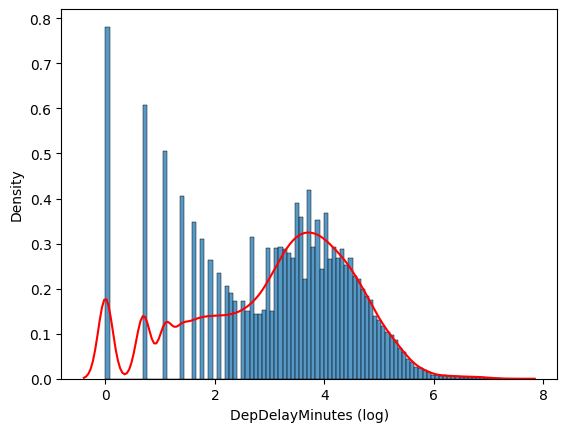

In [74]:
sns.histplot(np.log(filt['DepDelayMinutes']),stat='density')
sns.kdeplot(np.log(filt['DepDelayMinutes']),color='red')
plt.xlabel('DepDelayMinutes (log)')
plt.show()

Bueno, en realidad no es exactamente ni uno no el otro (así como estamos trabajando los datos), ¿pero se ven rasgos de ambos no? La hipérbola para pequeños delays y la campana de gauss para mayores.

Eso se lo conoce como una Mixtura de Distribuciones (en este caso, aparentemente entre una exponencial y una lognormal). Esto suele aparecer cuando estoy viendo como un conjunto fenómenos distintos.

#### Resumen

- Agarramos los datos de 2 años de vuelos sin discriminar por aerolínea, ni hora, ni aeropuerto de origen ni de destino.

- Un porcentaje importante de vuelos salen a tiempo (el 65%)
- Los que no salen a tiempo, tienen un delay que tiene aspectos de distribución exponencial (pero no exactamente), y tal vez pueden aproximarse por una distribución log-normal que con más parámetros va a poder hacer un mejor trabajo de ajustar media y desvío de los datos.

En clases futuras podríamos ver si separar por aeropuerto o incluir otras variables hace que se vea más claro cuál es la distribución real (modelos de regresión).

#### Para trabajar en la clase

Dado la cantidad de datos, que no pueden ser manejados por Colab (ni ninguna PC convencional), vamos a analizar solo los datos de Delta Airlines en el aeropuerto de Roanoke, VA.

In [75]:
df_filtrado = df_vuelos.loc[(df_vuelos['Marketing_Airline_Network']== 'DL') & (df_vuelos['OriginCityName'] == 'Roanoke, VA')]

En esta clase vamos a mirar únicamente la columna `DepDelayMinutes`, que es efectivamente el tiempo de demora (0 si salió a tiempo). El dataset se presta para mucho más, pero eso se los dejamos a ustedes para lo que es análisis exploratorio y, luego, modelos de regresión.

¿Vemos cómo se ven los datos?

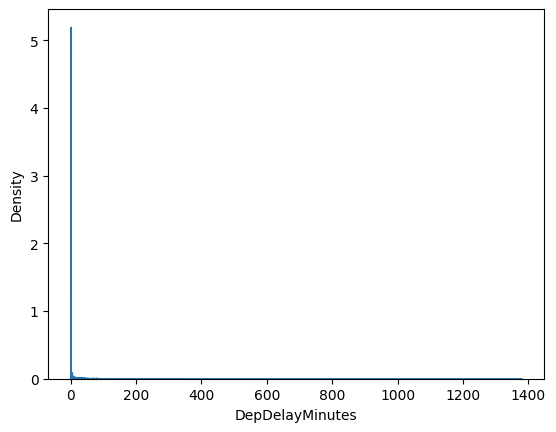

In [76]:
sns.histplot(df_filtrado['DepDelayMinutes'],stat='density',element='poly')
plt.show()

In [77]:
# Porcentaje de vuelos a tiempo
print('El porcentaje de vuelos que salen a tiempo es:',np.mean(df_filtrado['DepDelayMinutes']==0))

El porcentaje de vuelos que salen a tiempo es: 0.7351694915254238


Como ven hay un número gigante de 0's (vuelos a tiempo) que desnaturalizan un poco el gráfico. Veamos el histograma para los resultados **con** demora.



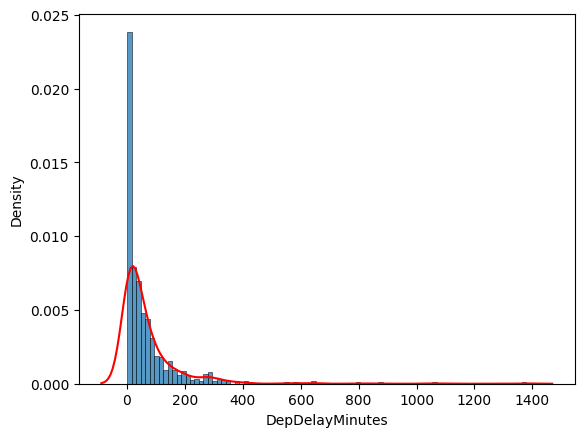

In [78]:
filt = df_filtrado[df_filtrado['DepDelayMinutes']!=0]
sns.histplot(filt['DepDelayMinutes'],stat='density')
sns.kdeplot(filt['DepDelayMinutes'],color='red')
plt.show()

El histograma se parece bastante a una exponencial, ¿no? Una característica de la distribución exponencial es que su media y su desvío estandar son iguales. Veamos si eso se cumple.

In [79]:
med = np.mean(filt['DepDelayMinutes'])
std = np.std(filt['DepDelayMinutes'])
print('La media es:',med)
print('El desvío es:',std)
#len(df_filtrado)

La media es: 68.01066666666667
El desvío es: 111.90402980331953


Ah... no son tan parecidos (100% de diferencia). Tal vez con un modelo exponencial a secas no me alcance para modelar la distribución.

Probemos otra cosa. Tomemos el logaritmo natural de los delays. Si fuese una distirbución exponencial, el histograma del logaritmo debiera verse como una hipérbola. En cambio, si la distribución fuese lognormal, se vería como una campana de Gauss.

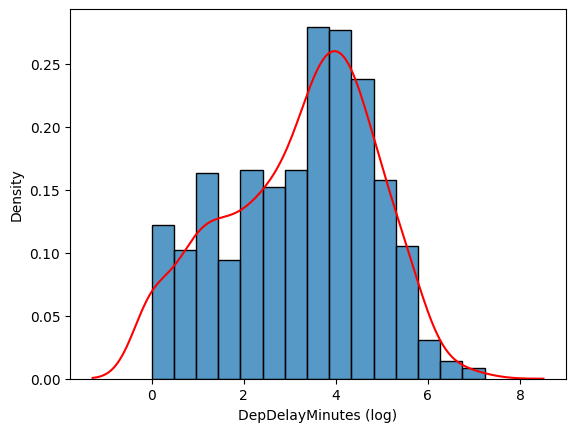

In [80]:
sns.histplot(np.log(filt['DepDelayMinutes']),stat='density')
sns.kdeplot(np.log(filt['DepDelayMinutes']),color='red')
plt.xlabel('DepDelayMinutes (log)')
plt.show()

Nuevamente, notarán que tampoco lo es exactamente.

### Etapa 1: Modelo para los vuelos con demora

#### Modelo 1: Gamma

Emepecemos probando un modelo Gamma

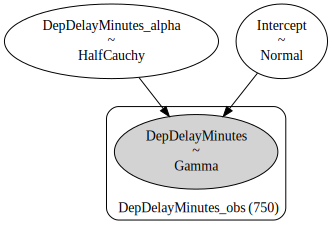

In [81]:
# Construyo un modelo de poisson en Bambi
model1 = bmb.Model("DepDelayMinutes ~ 1", df_filtrado[df_filtrado['DepDelayMinutes']>0],family='gamma')
model1.build()

# Ver el modelo
model1.graph()

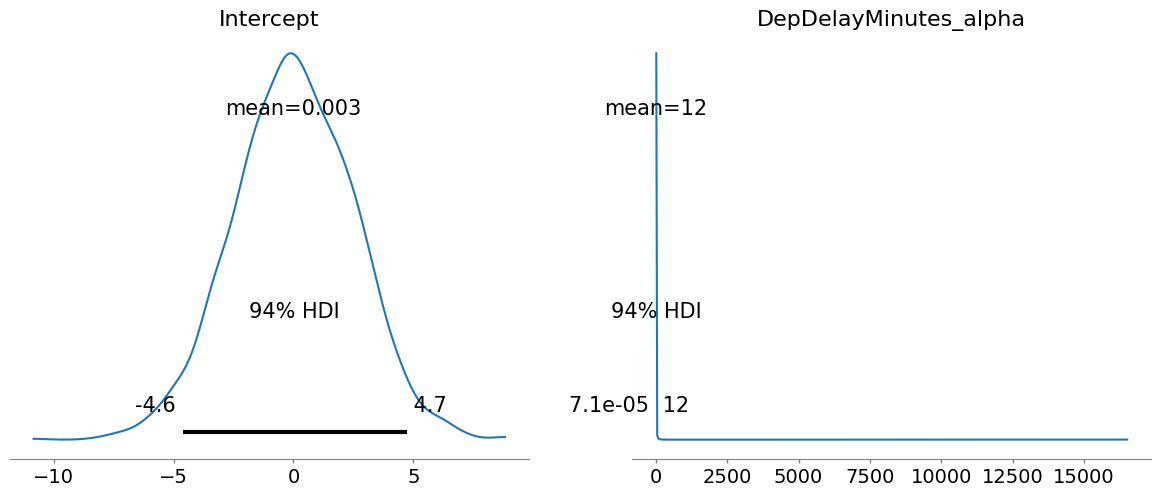

In [82]:
# Grafico las distribuciones a priori
model1.plot_priors()
plt.show()

In [83]:
# Hago la inferencia estadística
results1 = model1.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

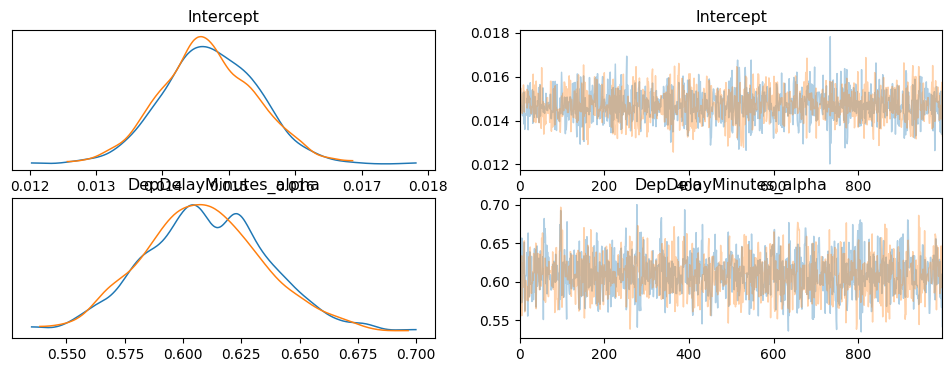

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              0.015  0.001   0.013    0.016      0.000      0.0   
DepDelayMinutes_alpha  0.609  0.026   0.559    0.657      0.001      0.0   

                       ess_bulk  ess_tail  r_hat  
Intercept                2104.0    1228.0    1.0  
DepDelayMinutes_alpha    1844.0    1150.0    1.0

In [84]:
# Diagnóstico de la Cadena
az.plot_trace(results1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results1)

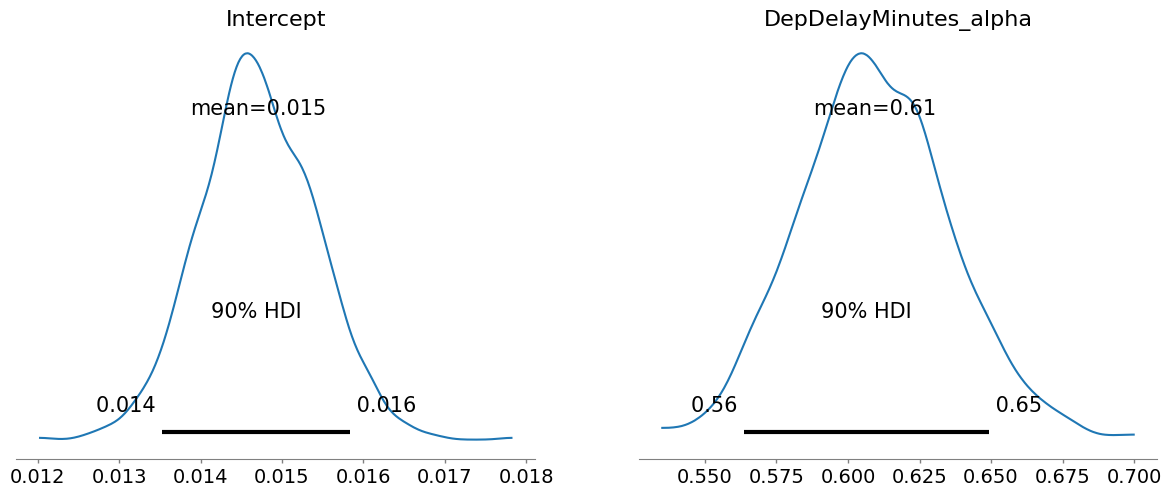

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept              0.015  0.001   0.014    0.016      0.000      0.0   
DepDelayMinutes_alpha  0.609  0.026   0.564    0.649      0.001      0.0   

                       ess_bulk  ess_tail  r_hat  
Intercept                2104.0    1228.0    1.0  
DepDelayMinutes_alpha    1844.0    1150.0    1.0

In [85]:
az.plot_posterior(results1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results1,hdi_prob=0.9)

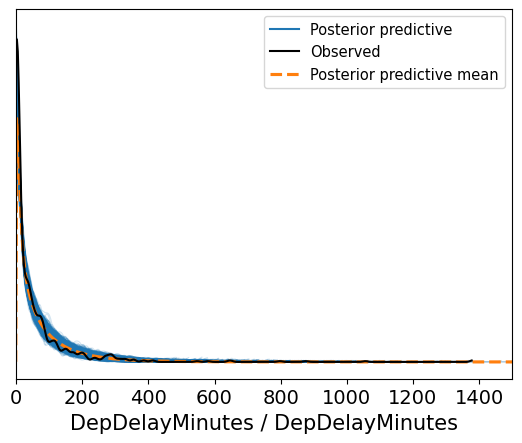

In [86]:
# Hacer predicciones con mi modelo
model1.predict(results1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results1)
#plt.xscale('log')
plt.xlim([0,1500])
plt.show()

#### Modelo 2: Exponencial

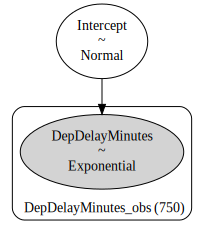

In [87]:
# Construyo un modelo de poisson en Bambi
model2 = bmb.Model("DepDelayMinutes ~ 1", df_filtrado[df_filtrado['DepDelayMinutes']>0],family='exponential')
model2.build()

# Ver el modelo
model2.graph()

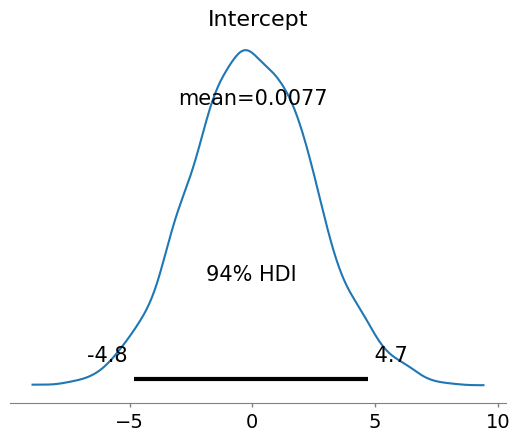

In [88]:
# Grafico las distribuciones a priori
model2.plot_priors()
plt.show()

In [89]:
# Hago la inferencia estadística
results2 = model2.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

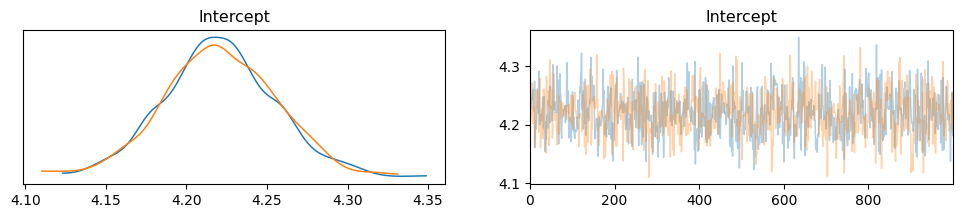

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.22  0.035   4.151    4.283      0.001    0.001     796.0   

           ess_tail  r_hat  
Intercept    1377.0    1.0

In [90]:
# Diagnóstico de la Cadena
az.plot_trace(results2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results2)

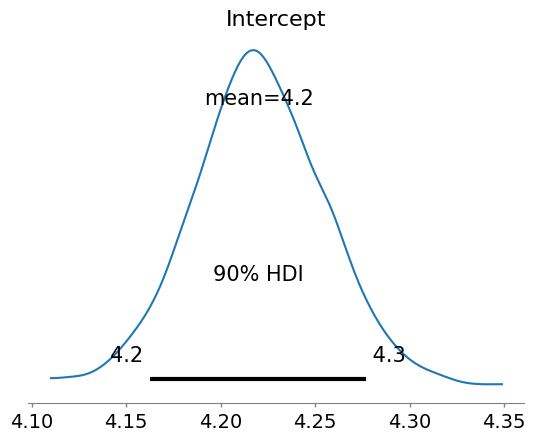

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.22  0.035   4.163    4.277      0.001    0.001     796.0   

           ess_tail  r_hat  
Intercept    1377.0    1.0

In [91]:
az.plot_posterior(results2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results2,hdi_prob=0.9)

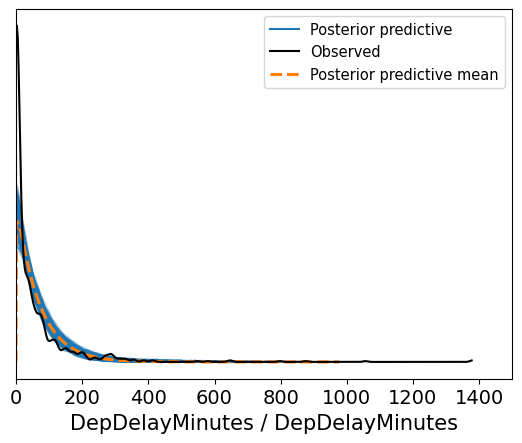

In [92]:
# Hacer predicciones con mi modelo
model2.predict(results2,kind='pps')

# Visualizar predicciones
az.plot_ppc(results2)
#plt.xscale('log')
plt.xlim([0,1500])
plt.show()

#### Modelo 3: Lognormal

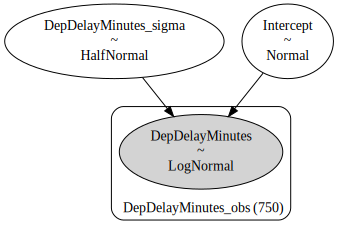

In [93]:
# Construyo un modelo de poisson en Bambi
likelihood = bmb.Likelihood("LogNormal", params=["mu", "sigma"], parent="mu")

# Set link function ----------------------------------------------
# 1. Pass a name that is known by Bambi
link = {"mu": "identity"}

# Construct the family -------------------------------------------
# Families are defined by a name, a Likelihood and a Link.
family = bmb.Family("lognormal", likelihood, link)

# Choose Priors (necessary for custom families) ------------------
priors = {"Intercept": bmb.Prior("Normal",mu=0,sigma=100),
  "sigma": bmb.Prior("HalfNormal", sigma=10)}


model3 = bmb.Model("DepDelayMinutes ~ 1", df_filtrado[df_filtrado['DepDelayMinutes']>0],family=family,priors=priors)
model3.build()

# Ver el modelo
model3.graph()

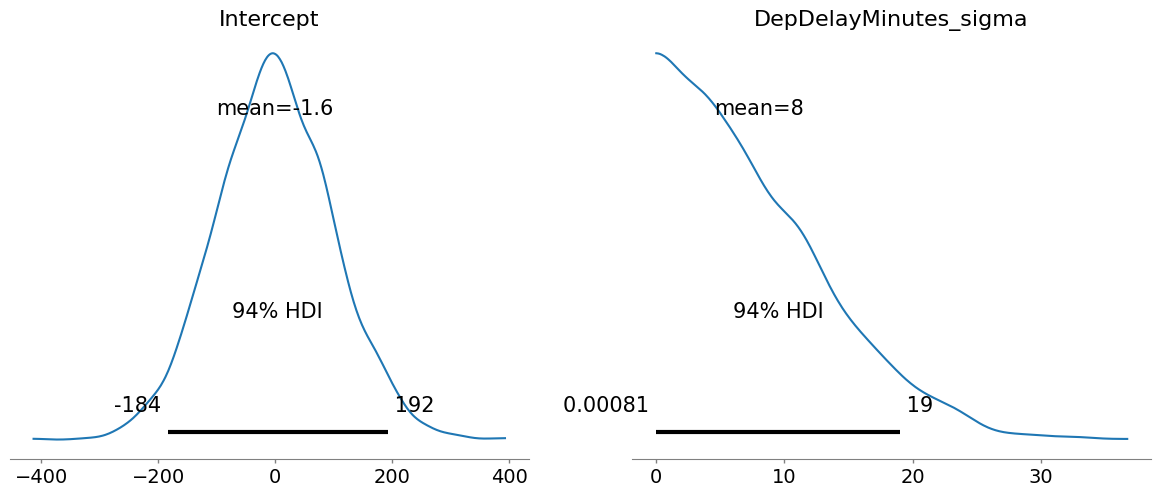

In [94]:
# Grafico las distribuciones a priori
model3.plot_priors()
plt.show()

In [95]:
# Hago la inferencia estadística
results3 = model3.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

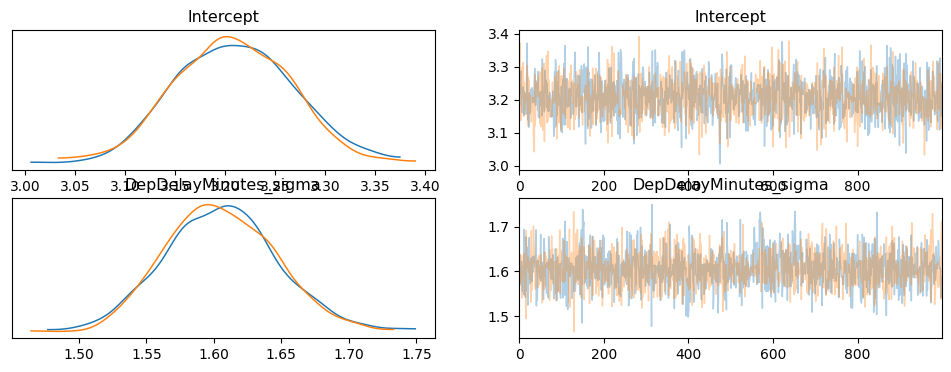

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              3.208  0.059   3.100    3.317      0.001    0.001   
DepDelayMinutes_sigma  1.605  0.041   1.528    1.679      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Intercept                2157.0    1338.0    1.0  
DepDelayMinutes_sigma    2051.0    1148.0    1.0

In [96]:
# Diagnóstico de la Cadena
az.plot_trace(results3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results3)

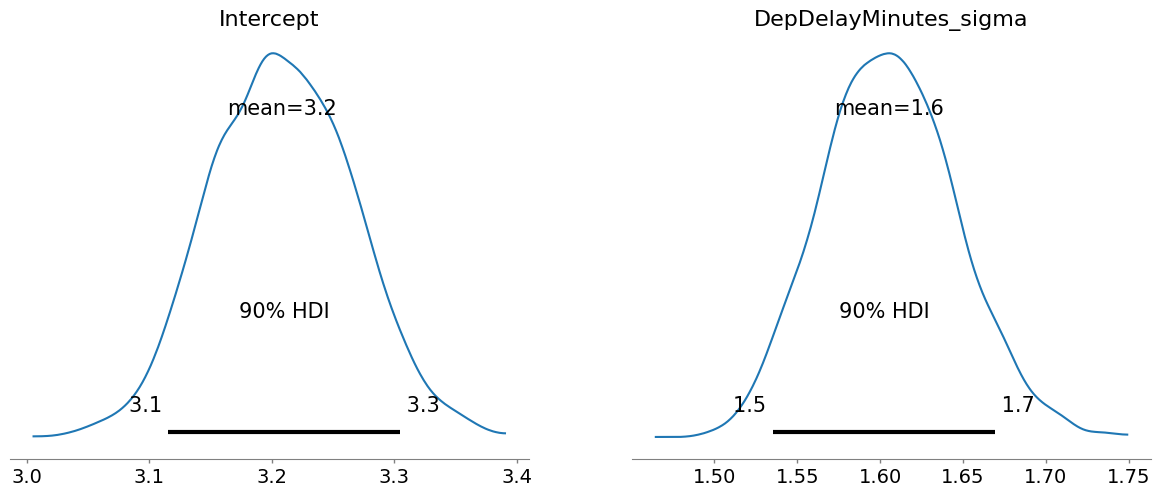

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept              3.208  0.059   3.116    3.305      0.001    0.001   
DepDelayMinutes_sigma  1.605  0.041   1.535    1.670      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Intercept                2157.0    1338.0    1.0  
DepDelayMinutes_sigma    2051.0    1148.0    1.0

In [97]:
az.plot_posterior(results3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results3,hdi_prob=0.9)

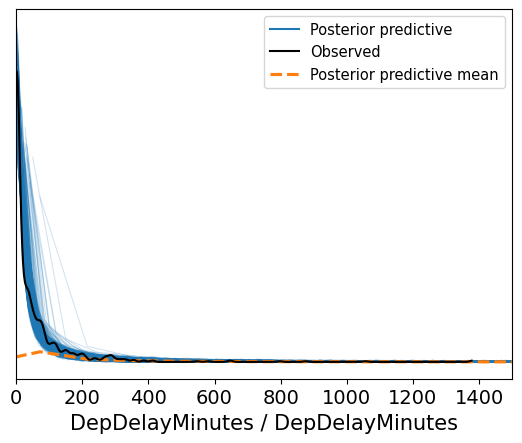

In [98]:
# Hacer predicciones con mi modelo
model3.predict(results3,kind='pps')

# Visualizar predicciones
az.plot_ppc(results3)
#plt.xscale('log')
plt.xlim([0, 1500])
plt.show()

### Evaluación de la predictiva - QQ-plots

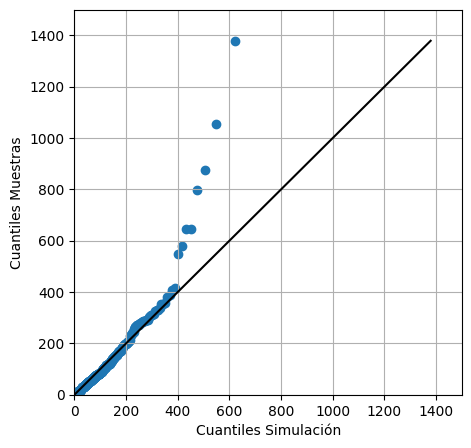

In [99]:
qqplot(np.ravel(results1.posterior_predictive['DepDelayMinutes']),df_filtrado['DepDelayMinutes'][df_filtrado['DepDelayMinutes']>0])
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([0,1500])
plt.ylim([0,1500])
plt.show()

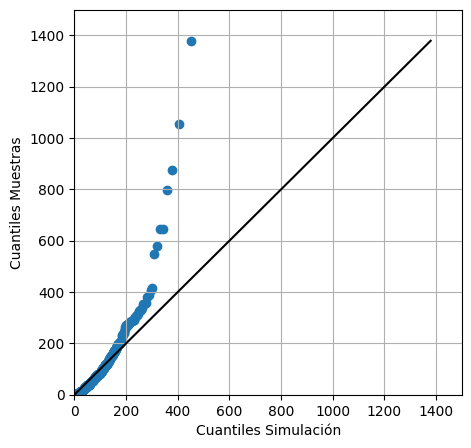

In [100]:
qqplot(np.ravel(results2.posterior_predictive['DepDelayMinutes']),df_filtrado['DepDelayMinutes'][df_filtrado['DepDelayMinutes']>0])
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([0,1500])
plt.ylim([0,1500])
plt.show()

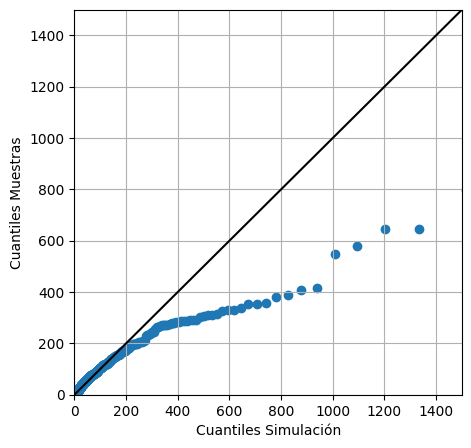

In [101]:
qqplot(np.ravel(results3.posterior_predictive['DepDelayMinutes']),df_filtrado['DepDelayMinutes'][df_filtrado['DepDelayMinutes']>0])
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([0,1500])
plt.ylim([0,1500])
plt.show()

Notarán que ningún modelo por si solo es particularmente bueno. Esto tiene que ver en parte porque los datos eran una combinación de distribuciones en realidad (fenómenos distintos metidos en una sola bolsa)!

### Selección de modelos (LOO-CV)

In [102]:
model_comp = {'Gamma':results1,'Exponencial':results2,'LogNormal':results3}
az_comp_loo = az.compare( model_comp, ic='loo',scale='deviance')
az_comp_loo

rank     elpd_loo     p_loo   elpd_diff    weight         se  \
LogNormal       0  7652.147528  1.631695    0.000000  0.685129  84.469884   
Gamma           1  7684.541073  2.655043   32.393544  0.047317  82.479676   
Exponencial     2  7832.921572  2.485094  180.774044  0.267554  90.574650   

                   dse  warning     scale  
LogNormal     0.000000    False  deviance  
Gamma        25.599012    False  deviance  
Exponencial  49.528068    False  deviance

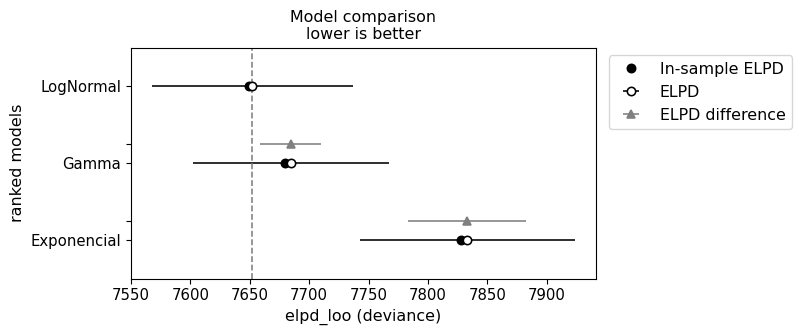

In [103]:
az.plot_compare(az_comp_loo,insample_dev=True)
plt.show()

En base a lo que hablamos antes, de los modelos planteados el mejor resulta ser el modelo LogNormal y en forma significativa! El `elpd_diff` es mayor a 4 y mayo a 1 vez el desvío estandar `se`.

Noten, igual, que los weights recomiendan hacer una Mezcla (Mixture) de la distribución LogNormal y Exponencial para una mejor predicción. Este tipo de modelos es más avanzado, por lo que lo dejamos para que busquen cómo hacerlo (Off Road)!

### Etapa 2: Modelo para todos los vuelos (Off Road)

Según la Etapa 1, la mejor forma (de las planteadas) para modelar las demoras en vuelos era el modelo logNormal. Pero para ello ignoramos todos los vuelos que salían a tiempo!

Cómo combino entonces ambos datos? Que hay datos que salen a tiempo y que, si no lo hacen, la demora sigue una lognormal?

Una opción sería construir dos modelos por separado:

1. uno que describe la posibilidad de salir a tiempo (calibrar un modelo de bernoulli)
2. uno que describre la demora dado que no salio a tiempo (calibrar el modelo lognormal). Si sale a tiempo, la demora es 0!

Si bien efectivamente esto se puede construir sobre la base de dos modelos distintos, se puede hacer todo de un saque notando que:

$$P(X=0) = \theta$$
$$P(X \neq 0) = p(X)$$

donde $\Theta$ es la probabilidad de salir a tiempo y $p(x)$ la función de distribución de la demoras. Este tipo de modelo se lo conoce como Hurdle Model, ya que se requiere saltar un obstáculo (que se genere la demora) para que aparezca la función de distribución. Este tipo de modelos es muy común, por ejemplo, para inundaciones.

En nuestro caso particular, tenemos 3 parámetros. Los 2 parámetros de la lognormal y el parámetro de la Bernoulli. Bambi hace todo esto en una línea de código!

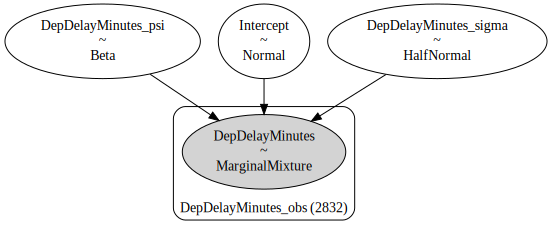

In [104]:
# Construyo un modelo de poisson en Bambi
model4 = bmb.Model("DepDelayMinutes ~ 1", df_filtrado,family='hurdle_lognormal')
model4.build()

# Ver el modelo
model4.graph()

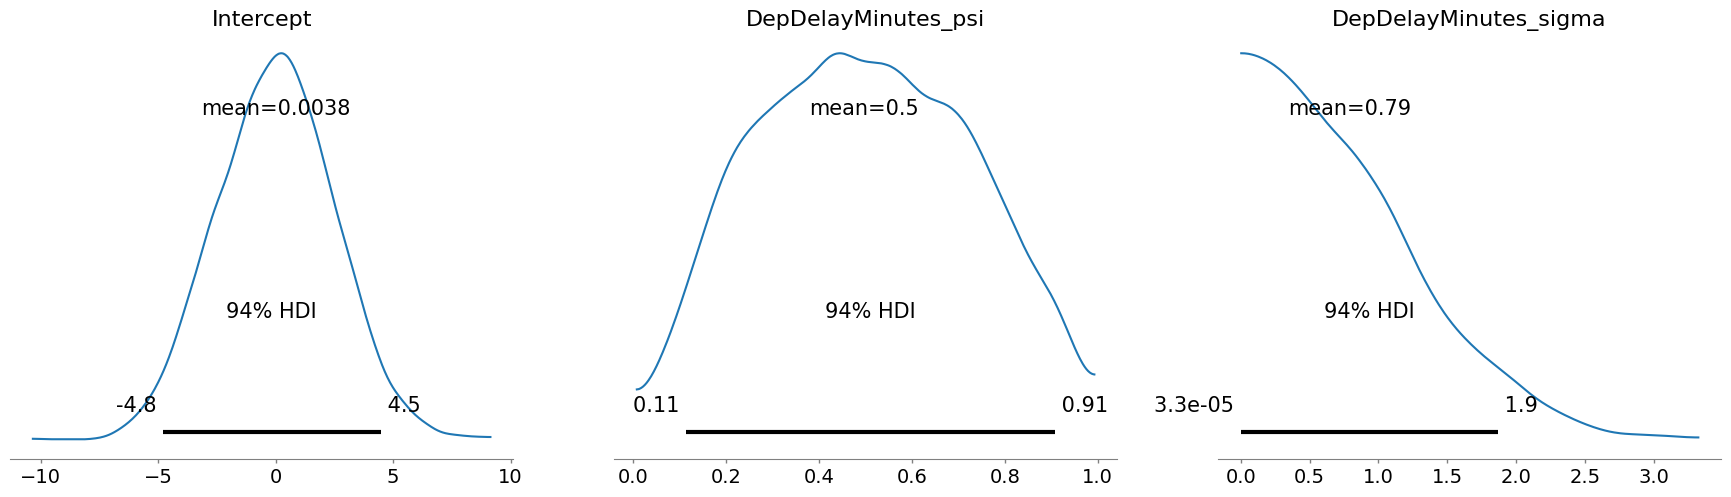

In [105]:
# Grafico las distribuciones a priori
model4.plot_priors()
plt.show()

In [106]:
# Hago la inferencia estadística
results4 = model4.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

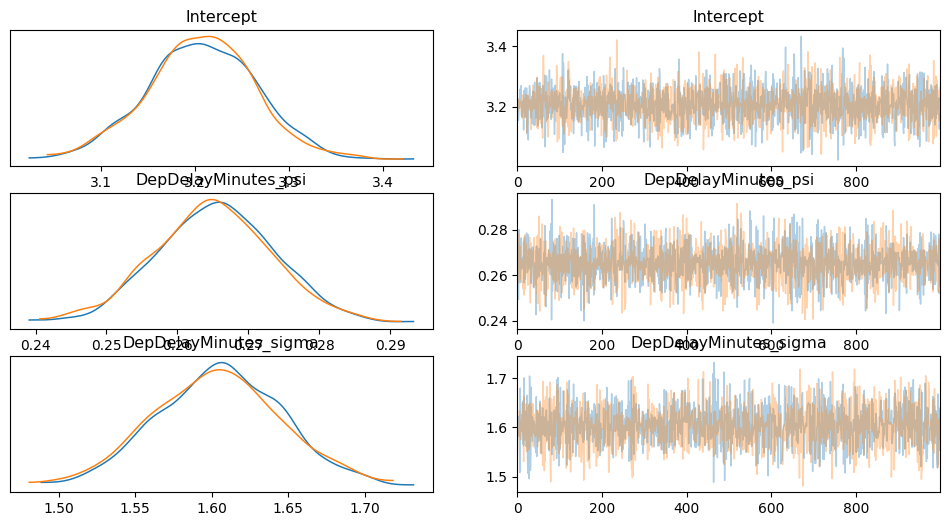

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              3.207  0.058   3.091    3.311      0.001    0.001   
DepDelayMinutes_psi    0.265  0.008   0.250    0.281      0.000    0.000   
DepDelayMinutes_sigma  1.604  0.041   1.528    1.683      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Intercept                3202.0    1455.0    1.0  
DepDelayMinutes_psi      2967.0    1360.0    1.0  
DepDelayMinutes_sigma    2801.0    1076.0    1.0

In [107]:
# Diagnóstico de la Cadena
az.plot_trace(results4, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results4)

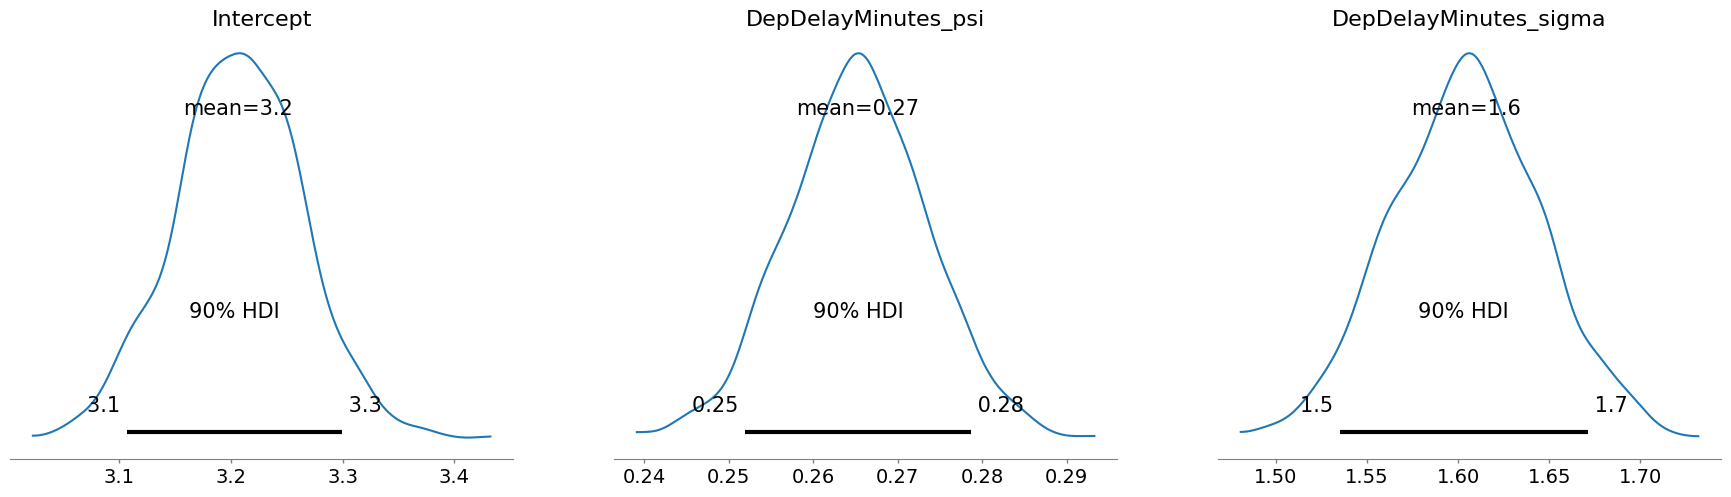

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept              3.207  0.058   3.107    3.300      0.001    0.001   
DepDelayMinutes_psi    0.265  0.008   0.252    0.279      0.000    0.000   
DepDelayMinutes_sigma  1.604  0.041   1.535    1.671      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Intercept                3202.0    1455.0    1.0  
DepDelayMinutes_psi      2967.0    1360.0    1.0  
DepDelayMinutes_sigma    2801.0    1076.0    1.0

In [108]:
az.plot_posterior(results4, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results4,hdi_prob=0.9)

Noten que los parámetros de la log-normal son básicamente iguales a los que vimos antes analizando sólo los vuelos demorados, mientras que el parámetro $\theta$ es básicamente 26%, que es el porcentaje de vuelos con demora según los datos (ver la sección de carga de datos). Así que todo tiene lógica!

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


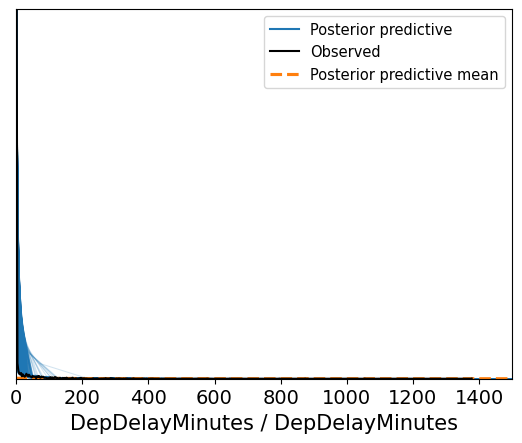

In [109]:
# Hacer predicciones con mi modelo
model4.predict(results4,kind='pps')

# Visualizar predicciones
az.plot_ppc(results4)
#plt.xscale('log')
plt.xlim([0,1500])
plt.ylim([0,1])
plt.show()

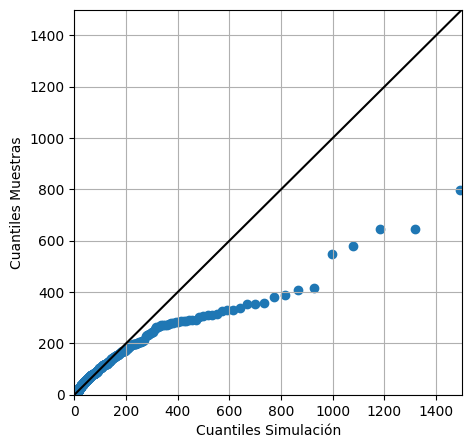

In [110]:
qqplot(np.ravel(results4.posterior_predictive['DepDelayMinutes']),df_filtrado['DepDelayMinutes'])
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([0,1500])
plt.ylim([0,1500])
plt.show()

Con esto tienen entonces, una herramienta más para modelar procesos tal vez más complejos que los que venimos viendo! Obviamente, para este caso no esperen magia, porque las demoras siguen estando modeladas con un modelo no muy correcto (habría que usar la mezcla de distribuciones mejor).

## Ejemplo de modelos más complejos: Acelerómetro Saturado (Off Road)

Este ejercicio tiene como objetivo mostrarles modelos de generación de datos tal vez un poco más complejos pero muy útiles a la hora de extraer información.

El registro que vemos a continuación es una historia de aceleraciones medida durante la demolición de un puente en la Ciudad de Buenos Aires. Lamentablemente, un error en la configuración del sensor hizo que la aceleración máxima capaz de ser registrada sea $0.02m/s^{2}$, menor a la aceleración máxima del terreno. En consecuencia, los datos se encuentran saturados.

El objetivo de este ejercicio es ver si podemos inferir las propiedades de las aceleraciones reales pese a tener información "incompleta".

### Carga de datos

En primer lugar, veamos los datos que tenemos disponibles.

In [111]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving vibraciones_demolicion.csv to vibraciones_demolicion.csv


In [112]:
#Se crea un DataFrame
df_vib = pd.read_csv(io.BytesIO(uploaded['vibraciones_demolicion.csv']))
df_vib.head()

time       acc    atrunc
0  0.000000 -0.002607 -0.002607
1  0.004202  0.014793  0.014793
2  0.008403  0.012393  0.012393
3  0.012605  0.011193  0.011193
4  0.016807  0.012993  0.012993

Tenemos 2 registros, uno de un acelerómetro que no saturó y otro que estaba seteado para medir aceleraciones de hasta $0.02m/s^{2}$. Si uno mira el registro de este último estaría tentado a descartar la medición.

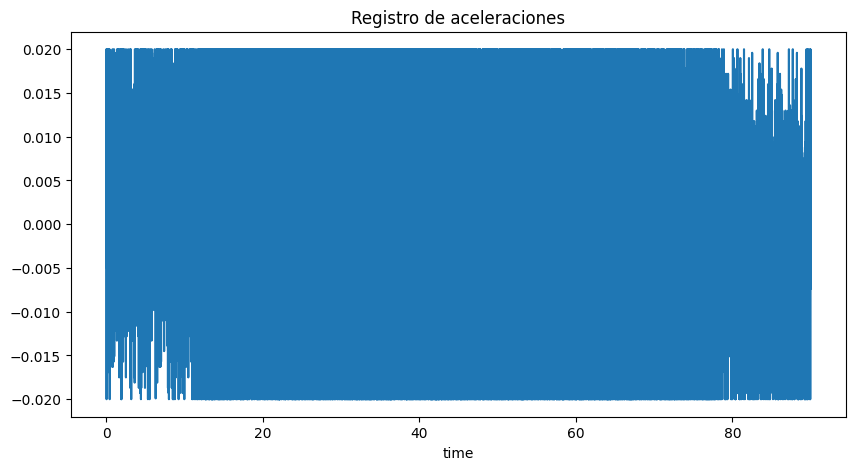

In [113]:
# Grafico
df_vib.plot(x='time', y='atrunc', legend=False, figsize=(10,5))
plt.title('Registro de aceleraciones')
plt.show()

Se ve claramente que el registro satura en 0.02 y -0.02, lo que en primera medida parece haber destrozado el ensayo ¡Sin embargo tiene mucha más información de lo que parece!

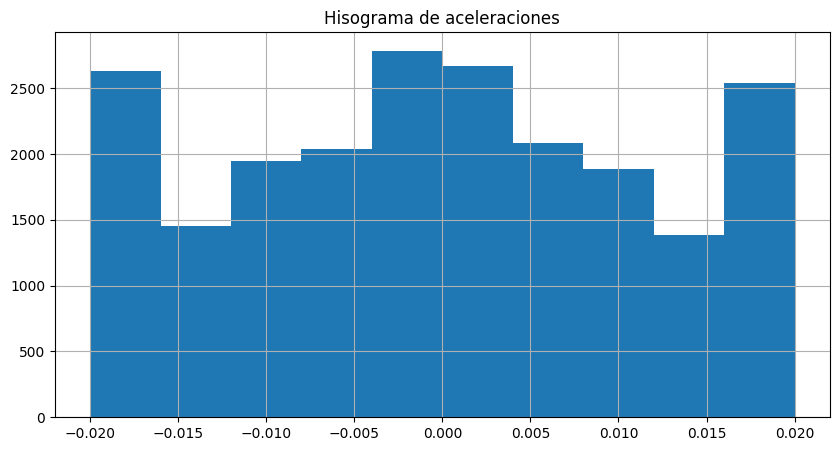

In [114]:
# Histograma
df_vib['atrunc'].hist(figsize=(10,5))
plt.title('Hisograma de aceleraciones')
plt.show()

Parece distinguirse el histograma de una VA normal o t-Student, pero con los valores de las colas todos acumulados en los límites del acelerómetro. Lo que vamos a hacer hoy es tratar de "salvar" el dataset y descubrir el fenómeno físico atrás de nuestras mediciones imperfectas.

####NOTA: el caso no saturado

Veamos qué se ve en el caso no saturado:

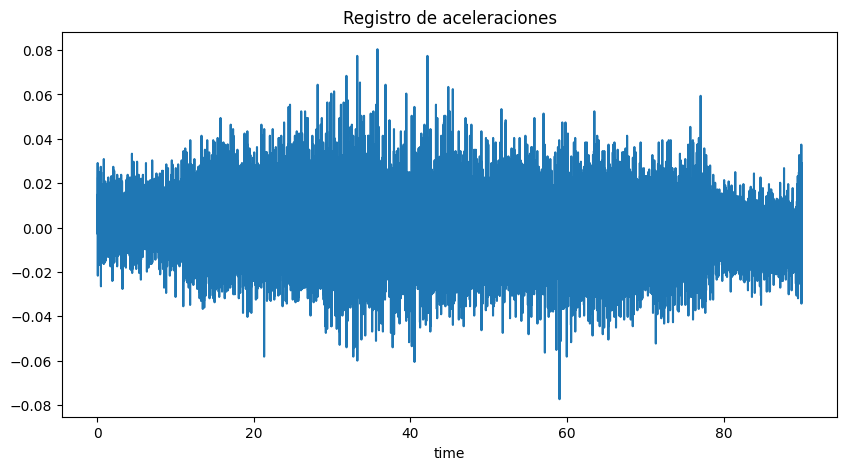

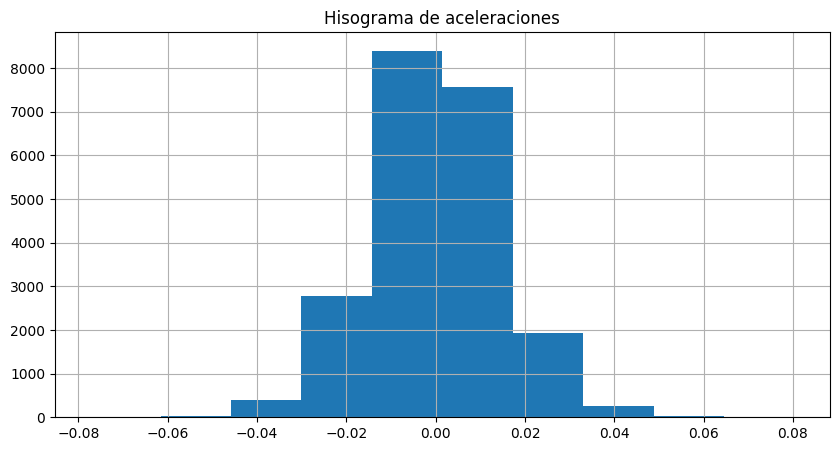

In [115]:
# Grafico
df_vib.plot(x='time', y='acc', legend=False, figsize=(10,5))
plt.title('Registro de aceleraciones')
plt.show()

# Histograma
df_vib['acc'].hist(figsize=(10,5))
plt.title('Hisograma de aceleraciones')
plt.show()

Veamos cuál es el desvío estandar

In [116]:
print('El desvío estandar (saturado) es:',np.std(df_vib['atrunc'],ddof=1))
print('El desvío estandar (sin saturar) es:',np.std(df_vib['acc'],ddof=1))

El desvío estandar (saturado) es: 0.011912646229630031
El desvío estandar (sin saturar) es: 0.014331027352647381


Fijensé que hay una diferencia de 15% entre el desvío estandar de los datos saturados y los datos del sensor bueno.

### Modelo de generación: Normal

Ahora queremos calibrar un modelo para obtener los parámetros del ruido blanco. Un ruido blanco se caracteriza por el siguiente modelo de generación de datos:

$$X \sim N\left(\mu,\sigma\right)$$

Es decir, una distribución normal (con valor medio nulo en realidad, pero dejemos que los datos nos lo digan)

Veamos qué pasa si uso directamente este modelo sobre los datos saturados.

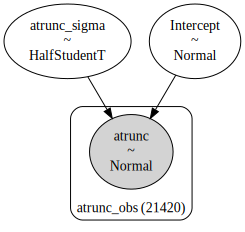

In [117]:
# Construyo un modelo de poisson en Bambi
model_1 = bmb.Model("atrunc ~ 1", df_vib)
model_1.build()

# Ver el modelo
model_1.graph()

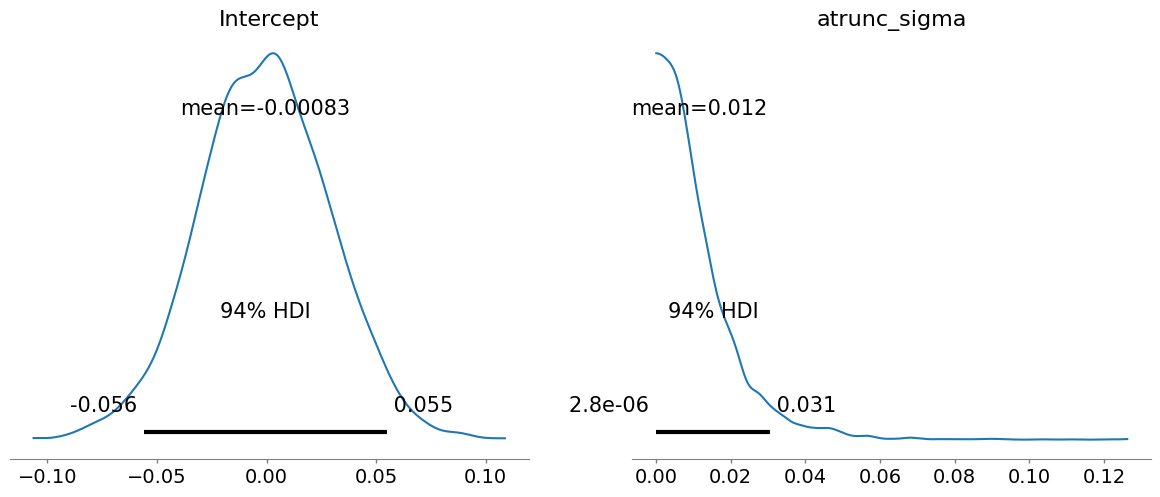

In [118]:
# Grafico las distribuciones a priori
model_1.plot_priors()
plt.show()

In [119]:
# Hago la inferencia estadística
results_1 = model_1.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

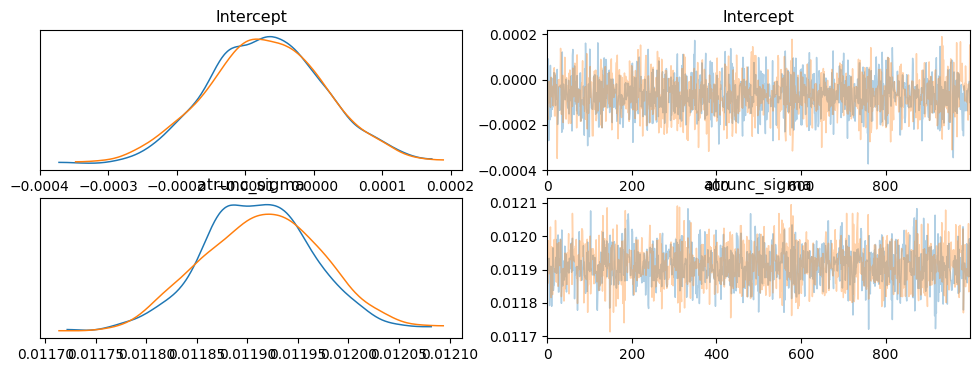

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -0.000  0.0  -0.000    0.000        0.0      0.0    2189.0   
atrunc_sigma  0.012  0.0   0.012    0.012        0.0      0.0    2153.0   

              ess_tail  r_hat  
Intercept       1514.0    1.0  
atrunc_sigma    1332.0    1.0

In [120]:
# Diagnóstico de la Cadena
az.plot_trace(results_1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_1)

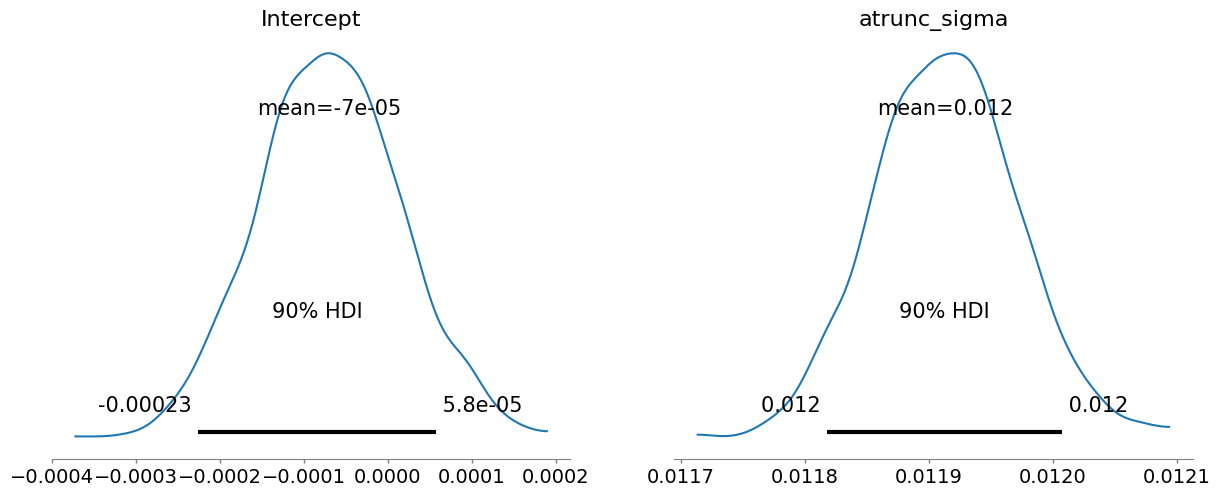

mean   sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -0.000  0.0  -0.000    0.000        0.0      0.0    2189.0   
atrunc_sigma  0.012  0.0   0.012    0.012        0.0      0.0    2153.0   

              ess_tail  r_hat  
Intercept       1514.0    1.0  
atrunc_sigma    1332.0    1.0

In [121]:
az.plot_posterior(results_1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_1,hdi_prob=0.9)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


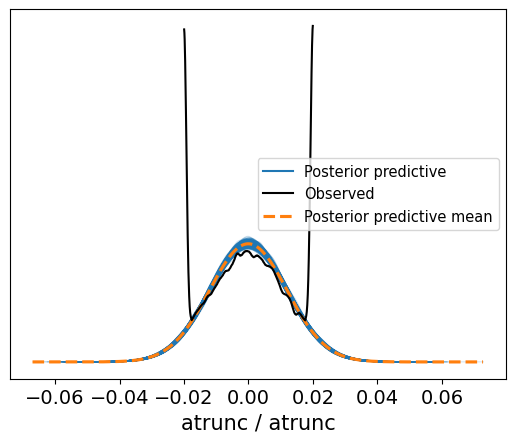

In [122]:
# Hacer predicciones con mi modelo
model_1.predict(results_1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_1)
plt.show()

Pueden ver arriba que los datos medidos presentan en realidad mayor desvío que lo que predice mi modelo! la campana negra es más chata que la naranja. Esto ocurre porque estoy ajustando a los datos como si no estuviesen saturados, y la enorme cantidad de datos en los límites me perjudica la estimación!

**NOTA**: Alguno puede estar pensando "¿por qué no elimino los datos saturados y trabajo únicamente con los no saturados?". Se lo dejamos para pensar a ustedes, pero los resultados también van a ser deficientes, ¡porque el modelo de generación normal tiene colas que sus datos truncados no! Existen formas de ajustar modelos truncados, así como ahora vamos a ver la forma de ajustar modelos censurados (Off road del Off road).

### Incorporación del efecto de la saturación: "Censura"

Yo en realidad no tengo datos $X$, las vibraciones en el campo. Yo tengo datos de $Z$, los datos de mi acelerómetro! El tema es que $Z$ y $X$ no siempre son iguales producto de la saturación. Es decir que:

$$ Z = \begin{cases} -0.02 & si\ X\leq-0.02\\
  X & si\ |X|<0.02\\
  0.02 & si\ X \geq 0.02\end{cases}$$

Esto se le conoce como un *modelo censurado* (en este paso partícular, con distribución normal). En Bambi, la forma de cargar un modelo censurado es relativamente sencilla!

Lo primero que vamos a hacer es agregar una columna a mi dataframe que indique si el dato está saturado o no:

- `right` significa que sólo se que el valor es mayor al indicado
- `left` significa que sólo se que el valor es menor al indicado
- `interval` siginifica que sólo se que el valor cae dentro de un intervalo
- `none` indica que el valor es conocido

In [123]:
df_vib['sat'] = np.where(df_vib['atrunc'] == 0.02, "right","none")
df_vib.loc[df_vib['atrunc'] == -0.02,'sat'] = "left"
df_vib.head()

time       acc    atrunc   sat
0  0.000000 -0.002607 -0.002607  none
1  0.004202  0.014793  0.014793  none
2  0.008403  0.012393  0.012393  none
3  0.012605  0.011193  0.011193  none
4  0.016807  0.012993  0.012993  none

Y ahora sí construyo mi modelo considerando que los datos están saturados!

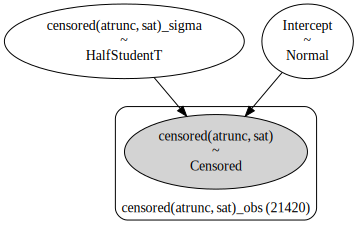

In [124]:
# Construyo un modelo de poisson en Bambi
model_2 = bmb.Model("censored(atrunc,sat) ~ 1", df_vib)
model_2.build()

# Ver el modelo
model_2.graph()

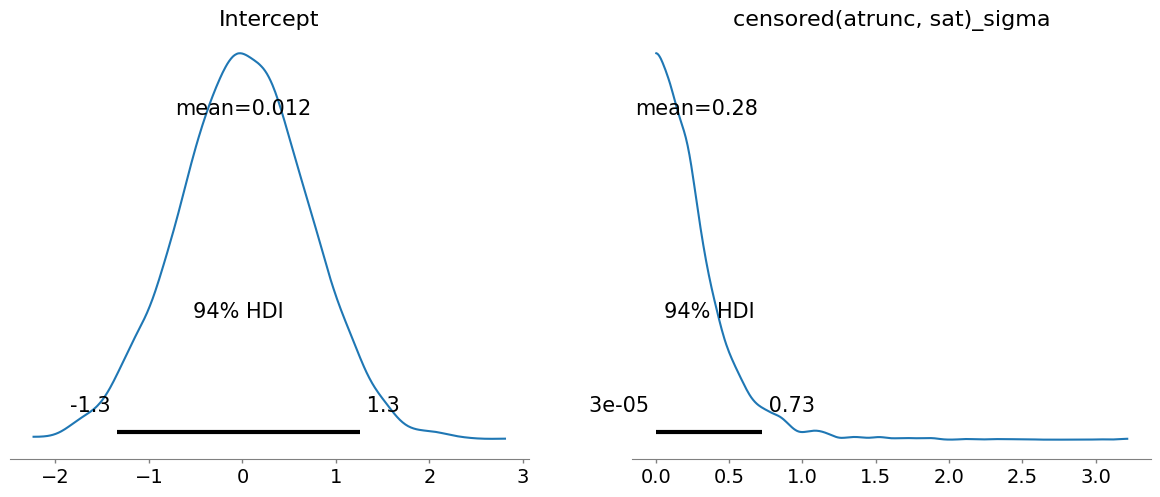

In [125]:
# Grafico las distribuciones a priori
model_2.plot_priors()
plt.show()

In [126]:
# Hago la inferencia estadística
results_2 = model_2.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

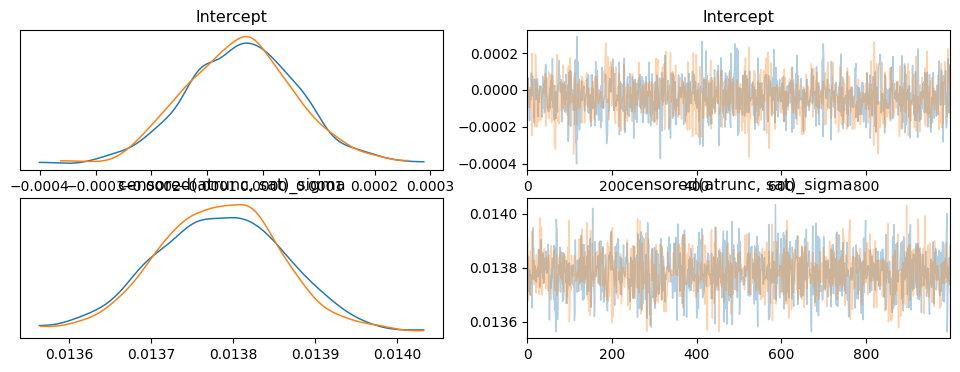

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                   -0.000  0.0  -0.000    0.000        0.0      0.0   
censored(atrunc, sat)_sigma  0.014  0.0   0.014    0.014        0.0      0.0   

                             ess_bulk  ess_tail  r_hat  
Intercept                      1858.0    1365.0    1.0  
censored(atrunc, sat)_sigma    2075.0    1311.0    1.0

In [127]:
# Diagnóstico de la Cadena
az.plot_trace(results_2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_2)

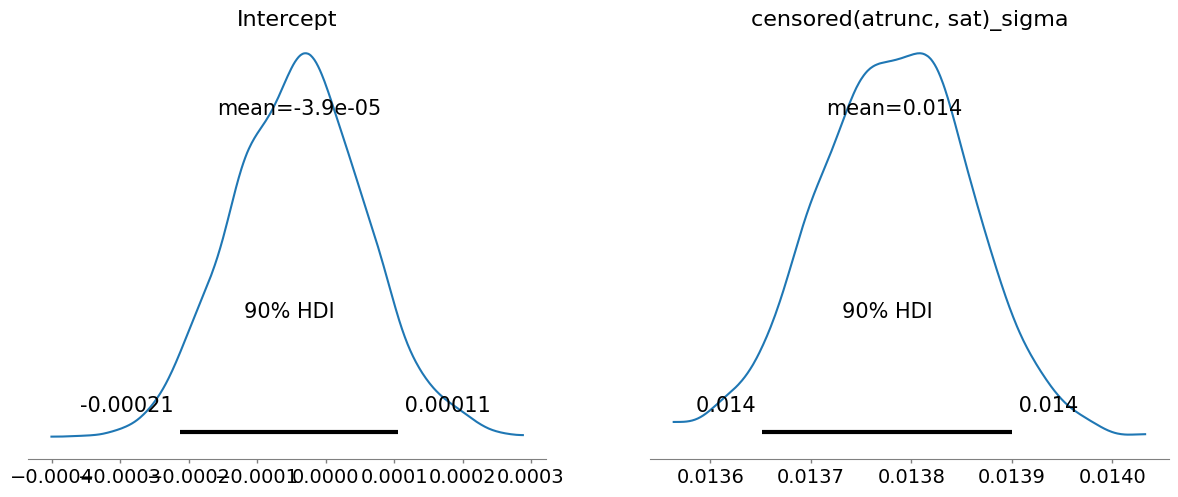

mean   sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept                   -0.000  0.0  -0.000    0.000        0.0      0.0   
censored(atrunc, sat)_sigma  0.014  0.0   0.014    0.014        0.0      0.0   

                             ess_bulk  ess_tail  r_hat  
Intercept                      1858.0    1365.0    1.0  
censored(atrunc, sat)_sigma    2075.0    1311.0    1.0

In [128]:
az.plot_posterior(results_2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_2,hdi_prob=0.9)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


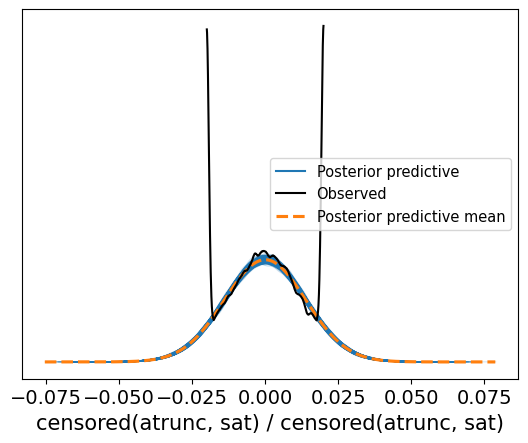

In [129]:
# Hacer predicciones con mi modelo
model_2.predict(results_2,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_2)
plt.show()

Pueden ver arriba que ahora me empiezo a parecer mucho más a los datos!

### Modelo Truncado (ignorar datos saturados)

Como dijimos, otra opción es ignorar los datos que se saturaron. En este caso, podemos utilizar una función de distribución truncada, reconociendo que ningún dato visto puede superar los valores límites de saturación del sensor.

Por ejemplo, si el modelo era normal, usaremos un modelo normal truncado, que lo que hace es acotar el área de integración entre -0.02 y 0.02, y es escalar la función de distribución para que su área sea 1 entr esos límites!

Abajo queda escrito cómo hacerlo.

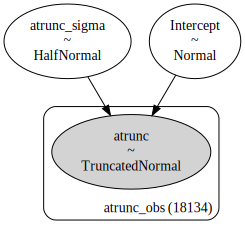

In [130]:
from functools import partial
from bambi.families.univariate import UnivariateFamily
import pymc as pm

def TruncatedNormal(name, mu, sigma, lower, upper, *args, dims=None, **kwargs):
    dist = pm.Normal.dist(mu=mu,sigma=sigma)
    return pm.Truncated(name, dist, lower=lower, upper=upper, *args, dims=dims, **kwargs)

dist_fn = partial(TruncatedNormal, lower=-0.02, upper=0.02)

likelihood = bmb.Likelihood("trunc", params=["mu","sigma"], parent='mu', dist=dist_fn)
links = {"mu": "identity","sigma": "identity"}
nexp_family = bmb.Family("trunNorm", likelihood, links)

# Elegir Priors ------------------
priors = {"Intercept": bmb.Prior("Normal",mu = 0, sigma=2),"sigma": bmb.Prior("HalfNormal",sigma=2)}

model_4 = bmb.Model("atrunc ~1",df_vib[(df_vib['atrunc']!=0.02) & (df_vib['atrunc']!=-0.02)],family=nexp_family,priors=priors)
model_4.build()

# Ver el modelo
model_4.graph()

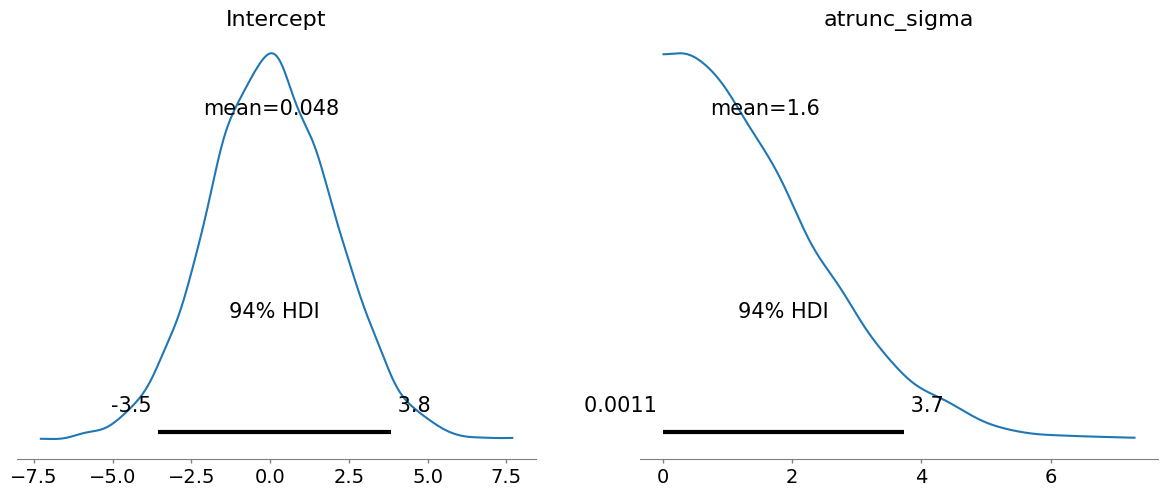

In [131]:
# Grafico las distribuciones a priori
model_4.plot_priors()
plt.show()

In [132]:
# Hago la inferencia estadística
results_4 = model_4.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

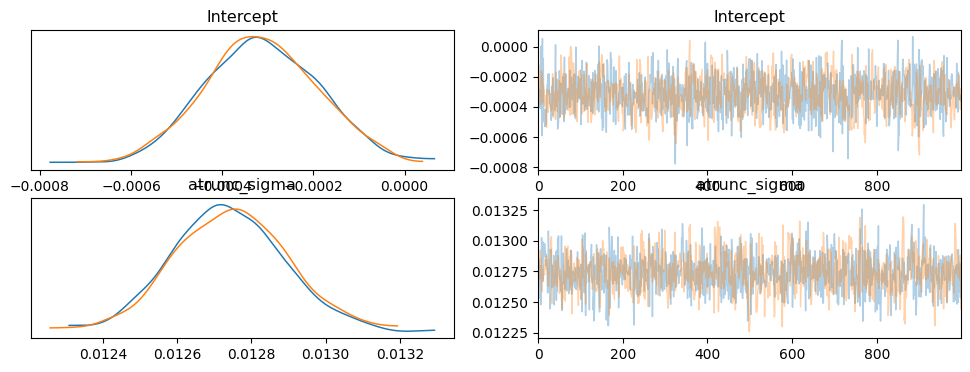

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -0.000  0.0  -0.001   -0.000        0.0      0.0    1105.0   
atrunc_sigma  0.013  0.0   0.012    0.013        0.0      0.0    1076.0   

              ess_tail  r_hat  
Intercept       1084.0    1.0  
atrunc_sigma     876.0    1.0

In [133]:
# Diagnóstico de la Cadena
az.plot_trace(results_4, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_4)

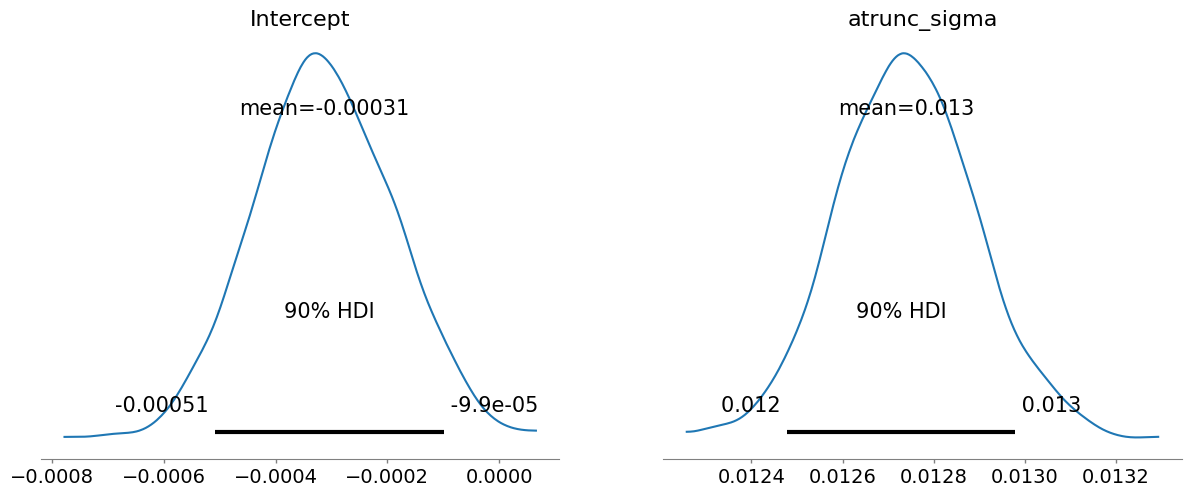

mean   sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -0.000  0.0  -0.001   -0.000        0.0      0.0    1105.0   
atrunc_sigma  0.013  0.0   0.012    0.013        0.0      0.0    1076.0   

              ess_tail  r_hat  
Intercept       1084.0    1.0  
atrunc_sigma     876.0    1.0

In [134]:
az.plot_posterior(results_4, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_4,hdi_prob=0.9)

Como pueden ver, los resultados tienen mayor variabilidad y se aproximan mejor al modelo original. Sin embargo, usar datos truncados implica una gran pérdida de información, por lo cual no esperen magia!

### Comparación con resultados con datos completos

Para demostrar la efectividad de nuestro modelo para "salvar la información" de mis datos saturados, veamos que resulta de usar los datos del sensor bien seteado (que no saturó)

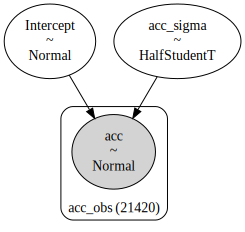

In [135]:
# Construyo un modelo de poisson en Bambi
model_3 = bmb.Model("acc ~ 1", df_vib)
model_3.build()

# Ver el modelo
model_3.graph()

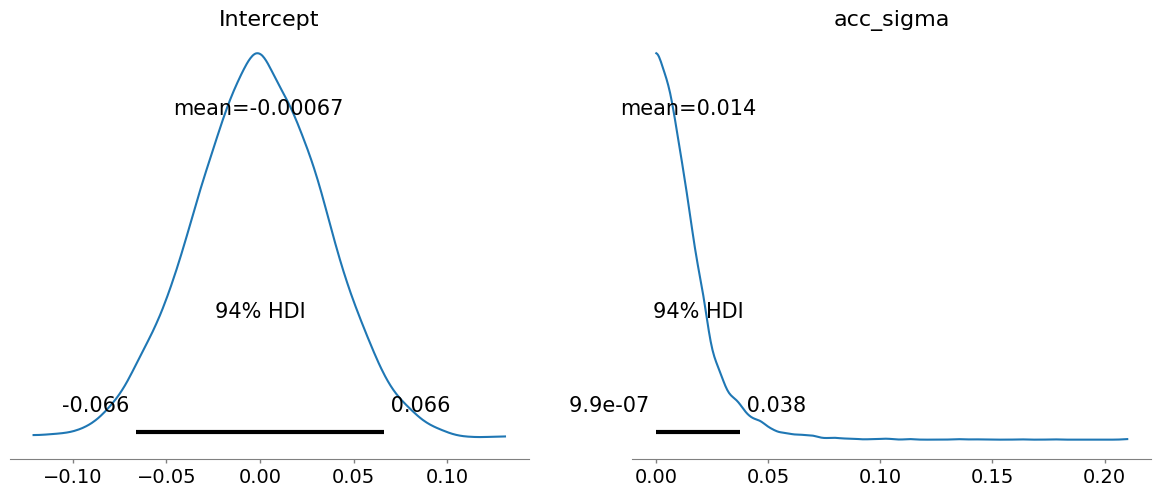

In [136]:
# Grafico las distribuciones a priori
model_3.plot_priors()
plt.show()

In [137]:
# Hago la inferencia estadística
results_3 = model_3.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

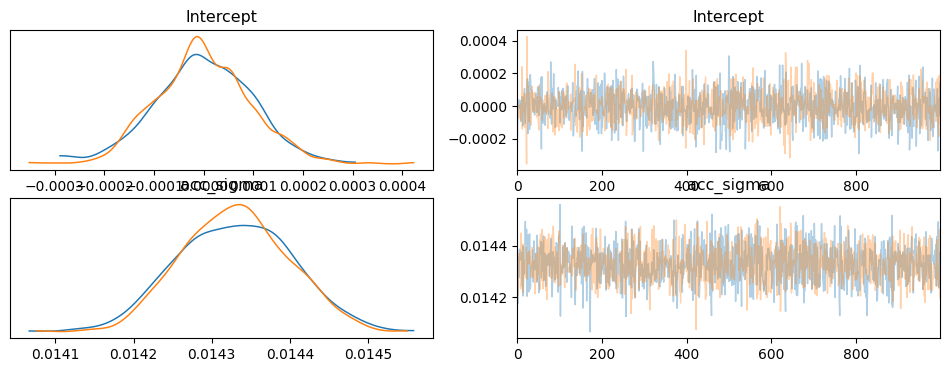

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.000  0.0  -0.000    0.000        0.0      0.0    2063.0   
acc_sigma  0.014  0.0   0.014    0.014        0.0      0.0    2183.0   

           ess_tail  r_hat  
Intercept    1474.0    1.0  
acc_sigma    1763.0    1.0

In [138]:
# Diagnóstico de la Cadena
az.plot_trace(results_3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_3)

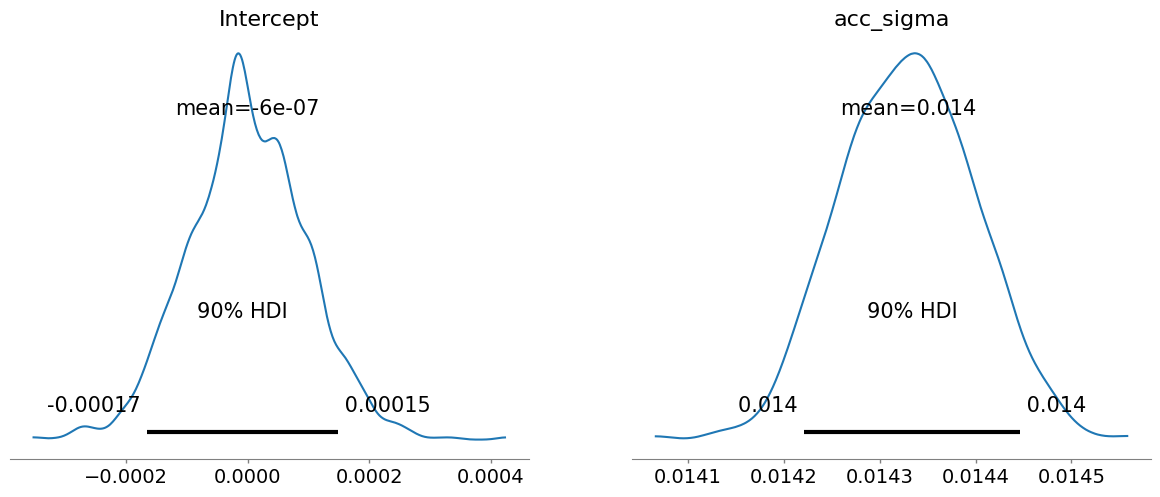

mean   sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.000  0.0  -0.000    0.000        0.0      0.0    2063.0   
acc_sigma  0.014  0.0   0.014    0.014        0.0      0.0    2183.0   

           ess_tail  r_hat  
Intercept    1474.0    1.0  
acc_sigma    1763.0    1.0

In [139]:
az.plot_posterior(results_3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_3,hdi_prob=0.9)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


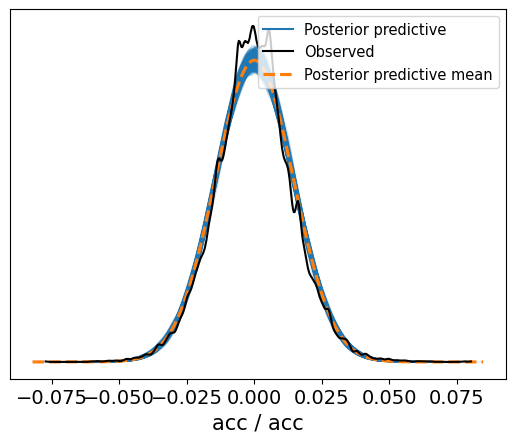

In [140]:
# Hacer predicciones con mi modelo
model_3.predict(results_3,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_3)
plt.show()

¡El modelo parece ajustar bastante bien dentro de todo!

Comparemos, entonces, la estimación del desvío estándar que ha hecho cada uno de nuestros modelos:

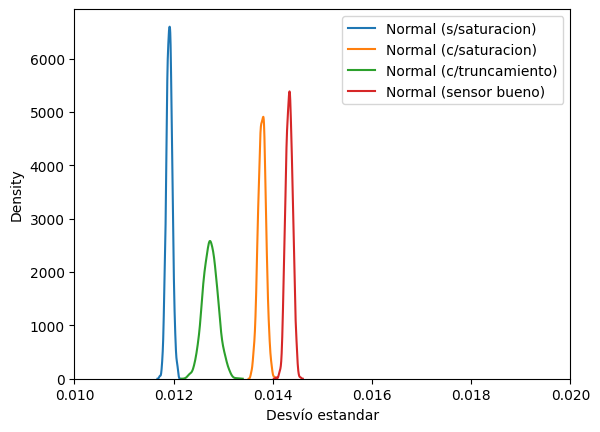

In [141]:
sns.kdeplot(np.ravel(results_1.posterior['atrunc_sigma']),label='Normal (s/saturacion)')
sns.kdeplot(np.ravel(results_2.posterior['censored(atrunc, sat)_sigma']),label='Normal (c/saturacion)')
sns.kdeplot(np.ravel(results_4.posterior['atrunc_sigma']),label='Normal (c/truncamiento)')
sns.kdeplot(np.ravel(results_3.posterior['acc_sigma']),label='Normal (sensor bueno)')
plt.legend()
plt.xlabel('Desvío estandar')
plt.xlim([0.01,0.02])
plt.show()

Como pueden ver, los datos que puedo rescatar de mi modelo saturado si incluyo el efecto de la saturación se parecen mucho más a los datos del sensor bueno.

El análisis "simple" de los datos saturados hubiese subestimado el desvío estandar un 15% respecto a los datos del sensor bueno, mientras que al incorporar en mi modelo el efecto de la saturación el error cometido (nunca me va a dar lo mismo, porque **perdí** información por un lado y el modelo no necesariamente era normal tampoco) es mucho menor. Si yo estuviese usando este dato para evaluar comfort o probabilidad de daño, errarle por 15% sería un problema. Pero como vemos acá, los datos saturados pueden ser "salvados" al intentar estimar $X$ (no medido) a partir de $Z$ medido. Lo que se conoce como ajustar una variable latente.

Noten, también, como el modelo con saturación tiene mayor incertidumbre que el del sensor bueno. Esto es producto de esa pérdida de información comentada anteriormente.